# Cart-pole swing-up problem: interactive demonstration

Hello and welcome. This is a Jupyter Notebook, a kind of document that can alternate between static content, like text and images, and executable cells of code.

This document ilustrates the Cart-pole swing-up test case of the paper: "Collocation Methods for Second Order Systems", submitted to RSS 2022.

In order to run the cells of code, you can select the cell and clic on the small "play" button in the bar above or press shift+enter. Alternatively, you can select the option "run -> run all cells" in order to run all the code in order. Beware that some cells can take several minutes!

All of the code used in this example is open-source and free to use.

[SymPy](https://www.sympy.org/en/index.html) is used for Symbolic formulation and manipulation of the problem.

[Numpy](https://numpy.org/) is used for numerical arrays and operations.

[CasADI](https://web.casadi.org/) is used for optimization.

[Chords](https://github.com/AunSiro/optibot) is the name of the package where we are compiling our code. We aim to produce a toolbox for Optimal Control Problems, focused on robotics, including a high level, readable and clean interface between the prior three packages.

## Package imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sympy import (symbols, simplify, Matrix, diff, lambdify)
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
from sympy.physics.mechanics import Lagrangian, ReferenceFrame, Point, Particle,inertia, RigidBody

In [3]:
from chords.symbolic import lagrange, diff_to_symb, SimpLagrangesMethod
from chords.numpy import unpack
from chords.symbolic import LagrangesMethod

In [4]:
from functools import lru_cache
from copy import copy

In [5]:
#SymPy vector-like latex rendering inizialization:

init_vprinting()

In [6]:
def integrate_hs_step(x0, xd0, xdc, xd1, h):
    return x0 + h * (xd0 + 4*xdc + xd1)/6

def integrate_hs(x0, xd_arr, xdc_arr, h):
    x_arr = [x0,]
    for ii in range(xd_arr.shape[0]-1):
        x_current = x_arr[-1]
        x_arr.append(
            integrate_hs_step(x_current, xd_arr[ii], xdc_arr[ii], xd_arr[ii+1], h)
        )
    return np.array(x_arr)

def hs_central_points(x_arr, x_d_arr, h):
    x = x_arr[:-1]
    x_n = x_arr[1:]
    x_d = x_d_arr[:-1]
    x_d_n = x_d_arr[1:]
    
    x_c = (x + x_n) / 2 + h / 8 * (x_d - x_d_n)
    
    return x_c

In [7]:
def get_jerk_impulse(v, v_c, h=1):
    
    # first segment, end slope:
    a1 = v[:-2, :]
    b1 = v_c[:-1, :]
    c1 = v[1:-1, :]

    s1 = a1 - 4*b1 + 3*c1

    # second segment, start slope:

    a2 = v[1:-1, :]
    b2 = v_c[1:, :]
    c2 = v[2:, :]

    s2 = -3*a2 + 4*b2 - c2

    jump = (s2-s1)/h
    return jump

def end_parab_slope(v, v_c, h=1):
    
    # first segment, end slope:
    a1 = v[:-2, :]
    b1 = v_c[:-1, :]
    c1 = v[1:-1, :]

    s1 = a1 - 4*b1 + 3*c1
    
    return s1/h
        
def get_jerk_heights(v, v_c, h=1):
    # first segment, :
    a = v[:-2, :]
    b = v_c[:-1, :]
    c = v[1:-1, :]

    j = 4*(a - 2*b + c)/(h**2)
    return j

## Symbolic Problem Modelling

The first step is to model our problem taking advantage of the high level object syntax of the mechanics module in SymPy

In [8]:
problem_name = 'cartpole_derivated'

In [9]:
# Creating symbols and dynamic symbols

m0, m1, l, t, g = symbols('m_0 m_1 l t g')
q0, q1 = dynamicsymbols('q_0 q_1')

In [10]:
# Definition of the physics system

N_in = ReferenceFrame('N')
pN = Point('N*')
pN.set_vel(N_in, 0)

P0 = pN.locatenew('P0', q0 * N_in.x)
P0.set_vel(N_in, q0.diff(t) * N_in.x)
cart_part = Particle('CartPart', P0, m0)
cart_part.potential_energy = m0 * g * P0.pos_from(pN).dot(N_in.y)

N1 = N_in.orientnew('N1', 'Axis', [q1, N_in.z])
P1 = P0.locatenew('P1', -l*N1.y)
P1.set_vel(N_in, P1.pos_from(pN).dt(N_in))

pend_part = Particle('PendPart', P1, m1)
pend_part.potential_energy = m1 * g * P1.pos_from(pN).dot(N_in.y)

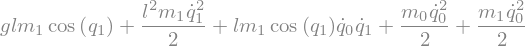

In [11]:
#Computing the Lagrangian

Lag_simp = Lagrangian(N_in, cart_part, pend_part)
Lag_simp

In [12]:
# Defining the control forces and external actions, and applying them to our system

u0, u1 = dynamicsymbols('u_0, u_1')
FL = [(P0, u0 * N_in.x)]#, (N1, u1 * N_in.z)]
LM_small = SimpLagrangesMethod(Lag_simp, [q0, q1], forcelist=FL, frame=N_in)

Generating M_inv
simplifying M_inv
simplifying RHS
Model completed


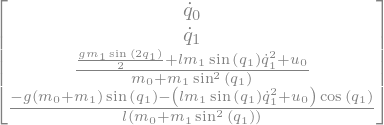

In [13]:
# Generating the dynamic equations

LM_small.form_lagranges_equations()
RHS_small = LM_small.rhs
RHS_small

# Normal cartpole test

### Casadi optimization

We have generated the system equations symbolicaly. Now, we translate them to CasADi objects in order to perform the optimization.

In [14]:
from chords.opti import Opti_Problem
from chords.analysis import interpolation, dynamic_errors
import time
from functools import lru_cache

In [15]:
from chords.numpy import store_results

In [16]:
from casadi import sum1, sum2

In [17]:
from chords.util import (sch_to_lab, sch_to_color, sch_to_long_label, scheme_kwargs, oct_fig_size, 
                         set_fonts, save_fig, plot_by_segments)
set_fonts()

In [18]:
from chords.casadi import implicit_dynamic_x_to_casadi_function, sympy2casadi

In [19]:
from chords.piecewise import interp_2d

In [20]:
#Numerical values of the paramenters

m0_n, m1_n = [1., 0.3]
l_n = 0.5
g_n = 9.81
params = [g_n, l_n, m0_n, m1_n]

#### Translating the Sympy Expression into a CasADi function

F_cas_simp = rhs_to_casadi_function(RHS_small[2:], 2)

In [21]:
#@lru_cache(maxsize=None)
def casadi_cartpole_prim(scheme, N, ini_guess='lin', solve_repetitions = 1, t_end = 2, verbose = False, silent = True):
    _opti = Opti_Problem(
        LM=LM_small,
        params = params,
        scheme = scheme,
        ini_guess= ini_guess,
        t_end = t_end,
        verbose=verbose,
        silent=silent,
    )
    _opti.dynamic_setup()
    _opti.opti_setup(N)
    _opti.initial_guess([0,0], [1,np.pi])
    _opti.u_sq_cost()
    _opti.apply_scheme()
    opti = _opti.opti
    X = _opti.opti_arrs['x']
    U = _opti.opti_arrs['u']
    X_s = _opti.opti_points['x_s']
    X_e = _opti.opti_points['x_e']
    N = _opti.N
    if 'parab' in scheme:
        U_c = _opti.opti_arrs['u_c']
        
   # Initial and final conditions
    opti.subject_to(X_s.T == [0, 0, 0, 0])
    opti.subject_to(X_e.T == [1, np.pi, 0, 0])
    
    # Appliying restrictions and action boundaries
    u_m = 20
    for ii in range(N):
        if 'parab' in scheme:
            opti.subject_to(opti.bounded(-u_m, U_c[ii,:] ,u_m))
        opti.subject_to(opti.bounded(-u_m,U[ii,:],u_m))
    opti.subject_to(opti.bounded(-u_m,U[-1, :],u_m))
    
    _opti.chrono_solve(solve_repetitions=solve_repetitions,)
    return _opti.results

In [22]:
_res = casadi_cartpole_prim('hs_mod_parab',25, 'lin', solve_repetitions=1,  silent=False, verbose=True)

Dynamics detected: Explicit Lagranges Method
Generating F function
x vars expected: [q_0, q_1, v_0, v_1]
x vars found: [q_1, v_0, v_1]
u vars found: [u_0]
Lambda variables are not separated from parameters
a variables are not separated from parameters
Parameters found: [g, l, m_0, m_1]
Function Arguments:
	x: [q_0, q_1, v_0, v_1]
	u: [u_0]
	params: [g, l, m_0, m_1]

Generating G function
x vars expected: [q_0, q_1, v_0, v_1]
x vars found: [q_1, v_0, v_1]
u vars found: [u_0]
Lambda variables are not separated from parameters
a variables are not separated from parameters
Parameters found: [g, l, m_0, m_1]
Function Arguments:
	q: [q_0, q_1]
	v: [v_0, v_1]
	u: [u_0]
	params: [g, l, m_0, m_1]


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/I

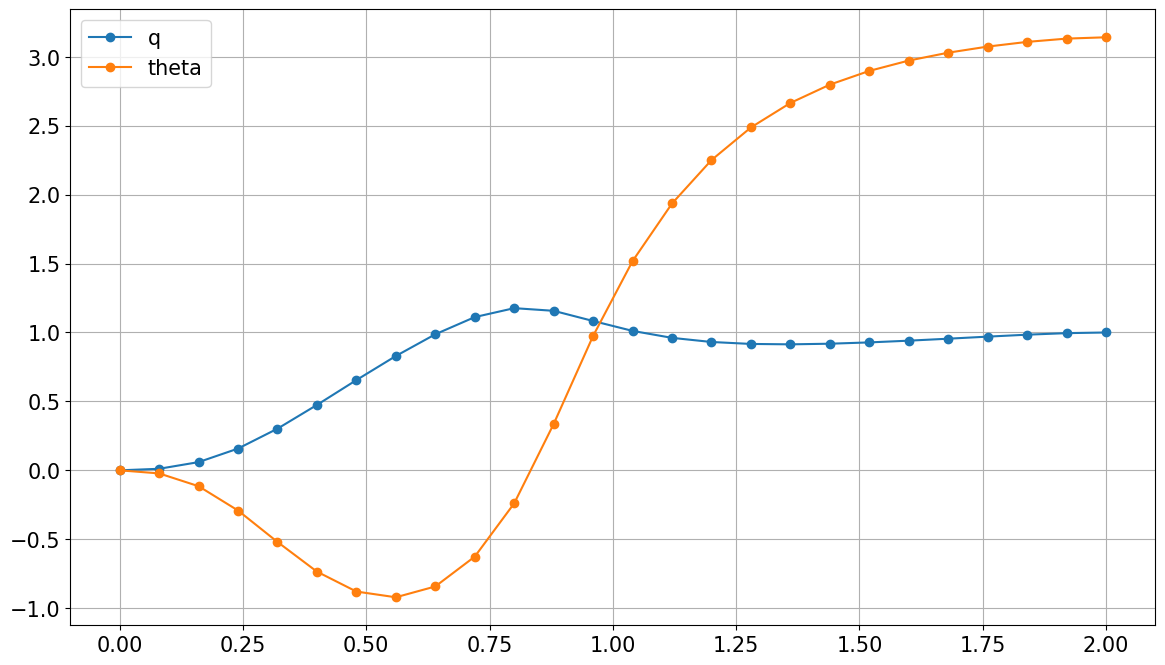

In [23]:
plt.figure(figsize=[14,8])
labels= ['q', 'theta']
for ii in range(2):
    plt.plot(_res['t'],_res['q'][:,ii], marker = 'o', label = labels[ii])
#    plt.plot(_res['t_c'],_res['q_c'][:,ii], 'o', label = labels[ii] + ' u_c')
plt.grid()
plt.legend()

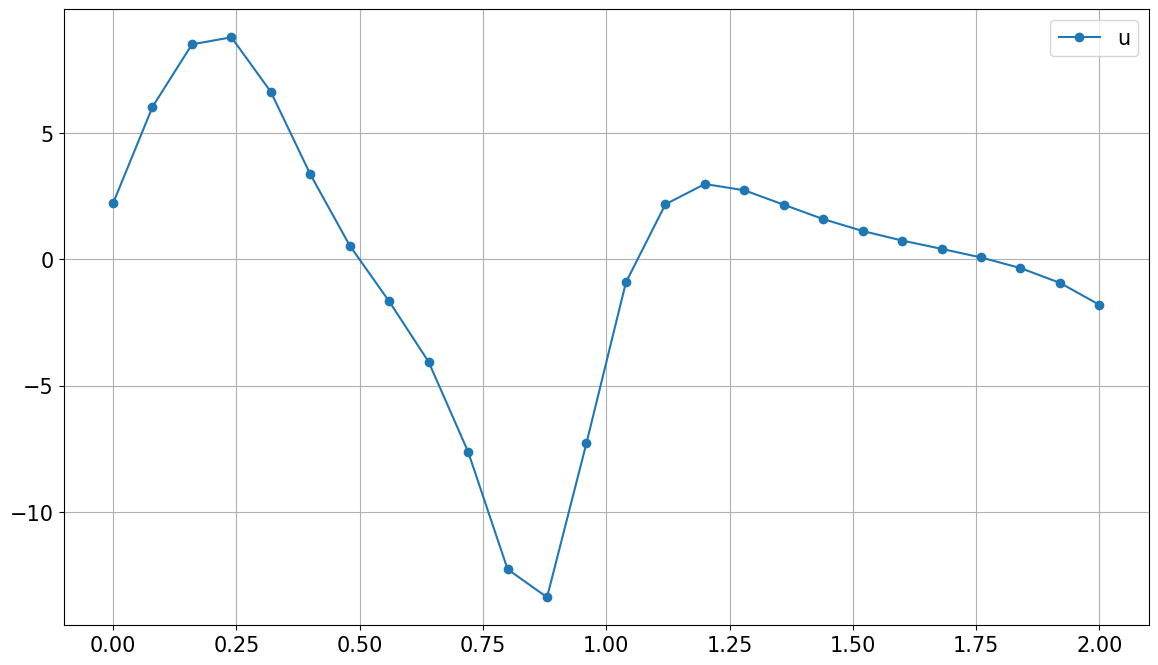

In [24]:
plt.figure(figsize=[14,8])
plt.plot(_res['t'],_res['u'][:], marker = 'o', label = 'u')
#    plt.plot(_res['t_c'],_res['q_c'][:,ii], 'o', label = labels[ii] + ' u_c')
plt.grid()
plt.legend()

# Cartpole derovated:

## Mode 1: derivated equation

In [25]:
RHS_d = RHS_small.diff(t)
RHS_d = simplify(RHS_d)

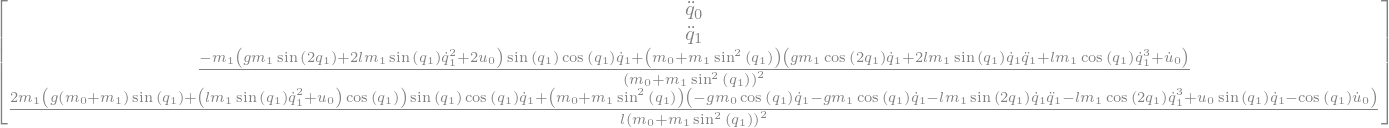

In [26]:
RHS_d

In [27]:
RHS_d_exp = RHS_small.copy()

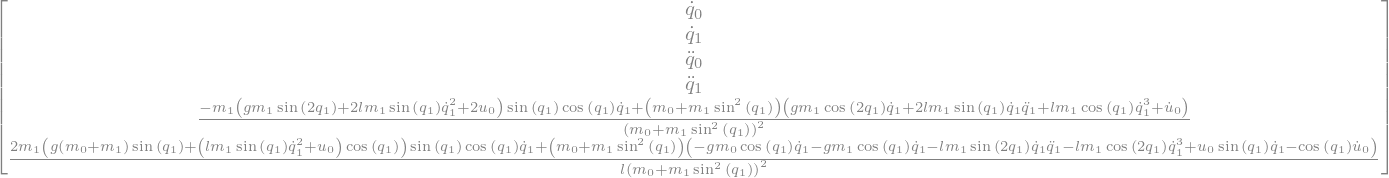

In [28]:
RHS_d_exp = Matrix([RHS_small[i] for i in [0,1]]+[RHS_d[i] for i in range(4)])
RHS_d_exp

In [29]:
q2 = dynamicsymbols('q_2')
q2d = q2.diff()
q2dd = q2d.diff()

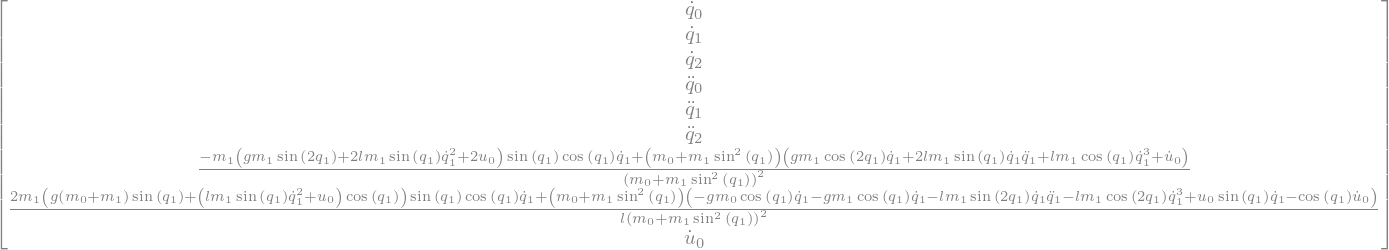

In [30]:
RHS_d_w = RHS_d_exp.row_insert(2, Matrix([q2d]))
RHS_d_w = RHS_d_w.row_insert(5, Matrix([q2dd]))
RHS_d_w = RHS_d_w.row_insert(8, Matrix([u0.diff()]))
RHS_d_w

In [31]:
x = dynamicsymbols('x_0:9')

In [32]:
x_d = [_i.diff() for _i in x]#symbols('\dot{x}_0:4')

In [33]:
RHSx=RHS_d_w.subs([
    [u0.diff(), u1],
    [u0, x[8]],
    [q0.diff(t,2), x[6]],
    [q1.diff(t,2), x[7]],
    [q2.diff(t,2), x[8]],
    [q0.diff(t), x[3]],
    [q1.diff(t), x[4]],
    [q2.diff(t), x[5]],
    [q0, x[0]],
    [q1, x[1]],
    [q2, x[2]]
])

RHS_d_w

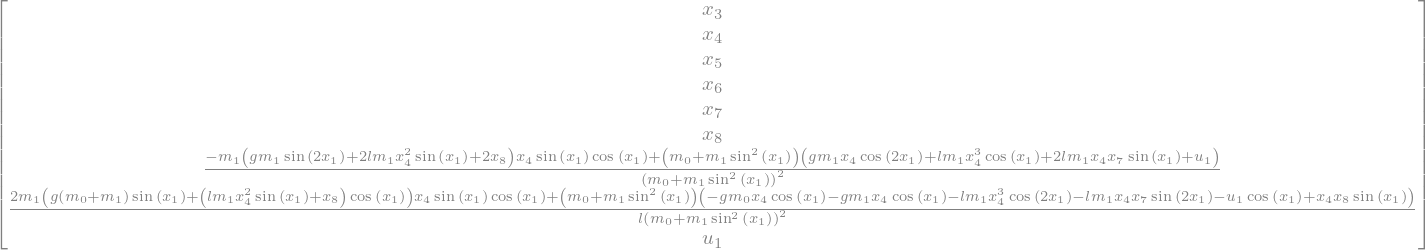

In [34]:
RHSx

In [35]:
x_d_mat = Matrix(x_d)

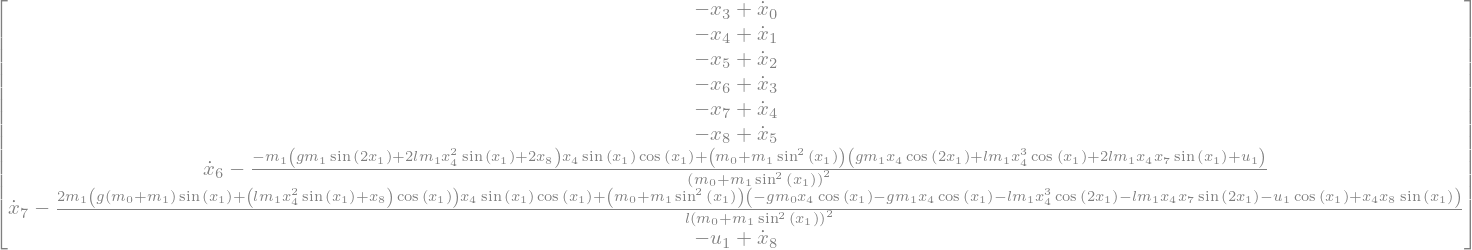

In [36]:
impl_D = x_d_mat-RHSx
impl_D

In [37]:
imp_F_x_cas = implicit_dynamic_x_to_casadi_function(impl_D, x, verbose=True)
imp_F_x_cas

x vars expected: [x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_0_dot, x_1_dot, x_2_dot, x_3_dot, x_4_dot, x_5_dot, x_6_dot, x_7_dot, x_8_dot]
x vars found: [x_0_dot, x_1, x_1_dot, x_2_dot, x_3, x_3_dot, x_4, x_4_dot, x_5, x_5_dot, x_6, x_6_dot, x_7, x_7_dot, x_8, x_8_dot]
u vars found: [u_1]
Lambda variables are separated from parameters
lambda vars found: []
a variables are not separated from parameters
Parameters found: [g, l, m_0, m_1]
Function Arguments:
	x: [x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8]
	x_dot: [x_0_dot, x_1_dot, x_2_dot, x_3_dot, x_4_dot, x_5_dot, x_6_dot, x_7_dot, x_8_dot]
	u: [u_1]
	lambdas: []
	params: [g, l, m_0, m_1]



Function(M:(x[9],x_dot[9],u,lambdas[0],params[4])->(residue[1x9]) MXFunction)

## Alternative Formulation:

$$ M(q)\ddot{q} + C(q,\dot{q}) \dot{q} + G(q) = Eu $$
$$ M \dddot{q} + (\dot{M} + C) \ddot{q} + \dot{C}\dot{q} + \dot{G} = E \dot{u}$$

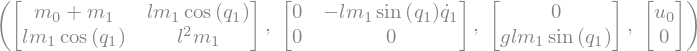

In [38]:
MM = LM_small.mass_matrix
CC = LM_small.C_matrix
GG = LM_small.G_matrix
EE = LM_small.ext_forces_matrix

MM, CC, GG, EE

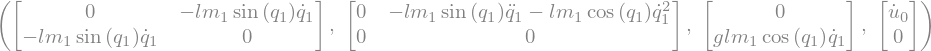

In [39]:
MM_d = MM.diff(t)
CC_d = CC.diff(t)
GG_d = GG.diff(t)
EE_d = EE.diff(t)

MM_d, CC_d, GG_d, EE_d

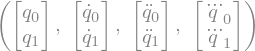

In [40]:
q = LM_small.q
q_d = q.diff()
q_dd = q_d.diff()
q_ddd = q_dd.diff()

q, q_d, q_dd, q_ddd

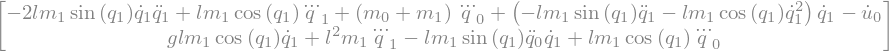

In [41]:
impl_dyn_alt = MM@q_ddd + (MM_d + CC)@q_dd + CC_d@q_d + GG_d - EE_d
impl_dyn_alt

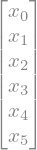

In [42]:
x_alt = Matrix(dynamicsymbols('x_0:6'))
x_d_alt = x_alt.diff()#symbols('\dot{x}_0:4')
x_alt

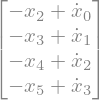

In [43]:
add_impl_mat =  x_d_alt[:-2,:]- x_alt[2:,:]
add_impl_mat

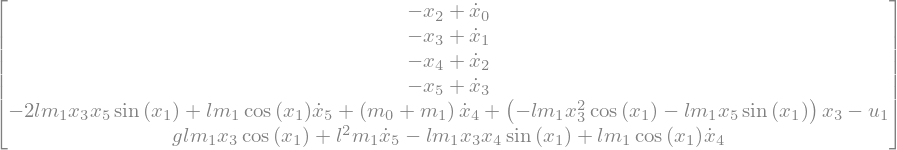

In [44]:
alt_impl_d = Matrix.vstack(add_impl_mat, impl_dyn_alt)
alt_impl_d = alt_impl_d.subs([
    [u0.diff(), u1],
    [q0.diff(t,3), x_d_alt[4]],
    [q1.diff(t,3), x_d_alt[5]],
    [q0.diff(t,2), x_alt[4]],
    [q1.diff(t,2), x_alt[5]],
    [q0.diff(t), x_alt[2]],
    [q1.diff(t), x_alt[3]],
    [q0, x_alt[0]],
    [q1, x_alt[1]],
])
alt_impl_d

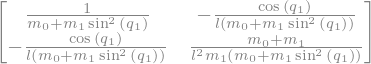

In [45]:
MM_inv = simplify(MM.pinv())
MM_inv

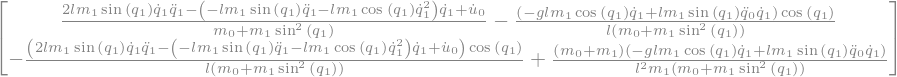

In [46]:
impl_dyn_alt_expl = MM_inv@ (- (MM_d + CC)@q_dd - CC_d@q_d - GG_d + EE_d)
impl_dyn_alt_expl

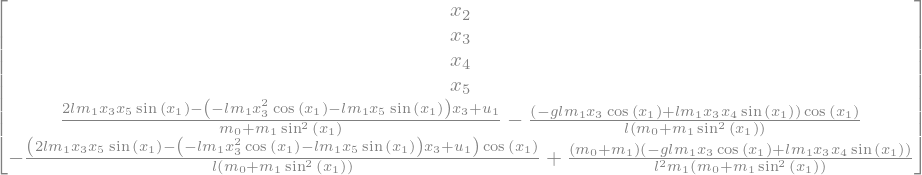

In [47]:
RHSx_alt = Matrix.vstack(x_alt[2:,:], impl_dyn_alt_expl)
RHSx_alt = RHSx_alt.subs([
    [u0.diff(), u1],
    [q0.diff(t,3), x_d_alt[4]],
    [q1.diff(t,3), x_d_alt[5]],
    [q0.diff(t,2), x_alt[4]],
    [q1.diff(t,2), x_alt[5]],
    [q0.diff(t), x_alt[2]],
    [q1.diff(t), x_alt[3]],
    [q0, x_alt[0]],
    [q1, x_alt[1]],
])
RHSx_alt

In [48]:
alt_imp_F_x_cas = implicit_dynamic_x_to_casadi_function(alt_impl_d, list(x_alt), verbose=True)
alt_imp_F_x_cas

x vars expected: [x_0, x_1, x_2, x_3, x_4, x_5, x_0_dot, x_1_dot, x_2_dot, x_3_dot, x_4_dot, x_5_dot]
x vars found: [x_0_dot, x_1, x_1_dot, x_2, x_2_dot, x_3, x_3_dot, x_4, x_4_dot, x_5, x_5_dot]
u vars found: [u_1]
Lambda variables are separated from parameters
lambda vars found: []
a variables are not separated from parameters
Parameters found: [g, l, m_0, m_1]
Function Arguments:
	x: [x_0, x_1, x_2, x_3, x_4, x_5]
	x_dot: [x_0_dot, x_1_dot, x_2_dot, x_3_dot, x_4_dot, x_5_dot]
	u: [u_1]
	lambdas: []
	params: [g, l, m_0, m_1]



Function(M:(x[6],x_dot[6],u,lambdas[0],params[4])->(residue[1x6]) MXFunction)

In [49]:
u_expr = (MM@q_dd + CC@q_d + GG)[0]
u_expr

In [50]:
params_sym = Matrix([g, l, m0, m1])
q0_d = q0.diff()
q0_dd = q0_d.diff()
q1_d = q1.diff()
q1_dd = q1_d.diff()
_u_expr_np_exp = lambdify(
    [q0, q1, q0_d, q1_d, q0_dd, q1_dd, params_sym],
    u_expr,
    'numpy'
)
def u_expr_np (q, q_d, q_dd, params):
    q0 = q[:,0]
    q1 = q[:,1]
    q0_d = q_d[:,0]
    q1_d = q_d[:,1]
    q0_dd = q_dd[:,0]
    q1_dd = q_dd[:,1]
    return _u_expr_np_exp(q0, q1, q0_d, q1_d, q0_dd, q1_dd, params)

In [51]:
import importlib
import chords
importlib.reload(chords.util)
importlib.reload(chords.bu_pseudospectral)
importlib.reload(chords.opti)
importlib.reload(chords.analysis)
importlib.reload(chords.piecewise)
importlib.reload(chords)
from chords.opti import Opti_Problem
from chords.piecewise import interpolated_array, interpolated_array_derivative, reduce_F, hs_accel_restr
from chords.analysis import dynamic_error
from chords.numpy import RHS2numpy, Sym2Fx
from chords.casadi import rhs_to_casadi_function
import casadi as cas

### Normal Cartpole Functions

In [52]:
F_nump = RHS2numpy(RHS_small, 2)

Function Arguments:
	x: [q_0, q_1, v_0, v_1]
	u: [u_0]
	params: [g, l, m_0, m_1]



In [53]:
G_nump = reduce_F(F_nump)

In [54]:
F_nump_w = Sym2Fx(RHSx, x, None, verbose=True)

x vars expected: [x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_0_dot, x_1_dot, x_2_dot, x_3_dot, x_4_dot, x_5_dot, x_6_dot, x_7_dot, x_8_dot]
x vars found: [x_1, x_3, x_4, x_5, x_6, x_7, x_8]
u vars found: [u_1]
Lambda variables are not separated from parameters
a variables are not separated from parameters
Parameters found: [g, l, m_0, m_1]
Function Arguments:
	x: [x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8]
	u: [u_1]
	params: [g, l, m_0, m_1]



In [55]:
F_nump_w_alt = Sym2Fx(RHSx_alt, x[:6], None, verbose=True)

x vars expected: [x_0, x_1, x_2, x_3, x_4, x_5, x_0_dot, x_1_dot, x_2_dot, x_3_dot, x_4_dot, x_5_dot]
x vars found: [x_1, x_2, x_3, x_4, x_5]
u vars found: [u_1]
Lambda variables are not separated from parameters
a variables are not separated from parameters
Parameters found: [g, l, m_0, m_1]
Function Arguments:
	x: [x_0, x_1, x_2, x_3, x_4, x_5]
	u: [u_1]
	params: [g, l, m_0, m_1]



In [56]:
F_cas = rhs_to_casadi_function(RHS_small, 2)

Function Arguments:
	x: [q_0, q_1, v_0, v_1]
	u: [u_0]
	params: [g, l, m_0, m_1]



In [57]:
G_cas = reduce_F(F_cas, mode='casadi')

In [58]:
def initial_cond_g(_op):
    X_s = _op.opti_points['x_s']
    opti = _op.opti
    a = X_s[:,6:8]
    q = X_s[:,:2]
    v = X_s[:,3:5]
    u = X_s[:,8]
    g = G_cas(q, v, u, params)
    opti.subject_to(a == g)

In [59]:
tt_in = np.array([7.89876773e-04, 2.11306260e-01, 8.70550865e-01, 1.18073996e+00, 1.99921012e+00])
uu_in = np.array([  1.9055811 ,   8.9161864 , -13.86953442,   2.92946272, -1.85406161])
tt_in, uu_in

(array([7.89876773e-04, 2.11306260e-01, 8.70550865e-01, 1.18073996e+00,
        1.99921012e+00]),
 array([  1.9055811 ,   8.9161864 , -13.86953442,   2.92946272,
         -1.85406161]))

In [60]:
list(params_sym)

In [61]:
impl_d_normal = MM@q_dd + CC@q_d + GG
_initial_cond_alt_np = lambdify(
    [q0, q1, q0_d, q1_d, q0_dd, q1_dd, params_sym],
    impl_d_normal[0],
    'numpy'
)

def initial_cond_alt(q, q_d, q_dd, params):
    q0 = q[:,0]
    q1 = q[:,1]
    q0_d = q_d[:,0]
    q1_d = q_d[:,1]
    q0_dd = q_dd[:,0]
    q1_dd = q_dd[:,1]
    return _initial_cond_alt_np(q0, q1, q0_d, q1_d, q0_dd, q1_dd, params)

_cas_q = cas.MX.sym("q", 2)
_cas_v = cas.MX.sym("v", 2)
_cas_a = cas.MX.sym("a", 2)
_cas_params = cas.MX.sym("p", 4)

_cas_vars = [_cas_q[0], _cas_q[1],
             _cas_v[0], _cas_v[1],
             _cas_a[0], _cas_a[1], 
             ]+cas.vertsplit(_cas_params)
_sym_vars = [q0, q1,
             q0_d, q1_d,
             q0_dd, q1_dd,
             ]+list(params_sym)


initial_cond_alt_cas_expr = sympy2casadi(impl_d_normal[1], _sym_vars, _cas_vars)

initial_cond_alt_cas = cas.Function(
        "F_condition",
        [_cas_q, _cas_v, _cas_a, _cas_params],
        [initial_cond_alt_cas_expr],
        ['q', 'v','a', 'params'],
        ['init_constr'],)

In [62]:
initial_cond_alt_cas([0,1],[1,2],[3,4], params)

DM(1.78136)

In [63]:
@lru_cache(maxsize=None)
#@store_results
def casadi_cartpole_derivated(scheme,
                              N,
                              ini_guess='lin',
                              solve_repetitions = 1,
                              t_end = 2,
                              order = 2,
                              cost_f = 'j+u',
                              u_parab = False,
                              model = 'u_in_x',
                              verbose = False,
                              silent = True):
    
    if model == 'u_in_x':
        dyn_f = imp_F_x_cas
        n_x = 9
    elif model == 'impl_diff':
        dyn_f = alt_imp_F_x_cas
        n_x = 6
        if cost_f in ['u', 'j+u']:
            raise ValueError(f'Model {model} not compatible with cost function {cost_f}')
    else:
        raise ValueError(f'Unrecognized model {model}')
    
    _opti = Opti_Problem(
        LM=dyn_f,
        params = params,
        scheme = scheme,
        ini_guess= ini_guess,
        t_end = t_end,
        verbose=verbose,
        silent=silent,
    )
    
    _opti.dynamic_setup('f_x_impl', n_x//order, 1, order = order)
    _opti.opti_setup(N)
    _opti.apply_scheme()
    
    if model  == 'u_in_x':
        if order == 3:
            _opti.initial_guess([0,0,0], [1,np.pi,0])
        elif order == 1:
            _opti.initial_guess([0,0,0, 0.5,np.pi/2,0, 0,0,0], [1,np.pi,0, 0.5,np.pi/2,0, 0,0,0])


        opti = _opti.opti
        X = _opti.opti_arrs['x']
        X_d = _opti.opti_arrs['x_d']
        J = _opti.opti_arrs['x_d'][:,6:8]
        W = _opti.opti_arrs['u']
        U = _opti.opti_arrs['x'][:,8]
        X_s = _opti.opti_points['x_s']
        X_e = _opti.opti_points['x_e']
        if 'hs' in scheme:
            X_c = _opti.opti_arrs['x_c']
            X_d_c = _opti.opti_arrs['x_d_c']
            U_c = _opti.opti_arrs['x_c'][:,8]
            J_c =_opti.opti_arrs['x_d_c'][:,6:8]
            if 'parab' in scheme:
                W_c = _opti.opti_arrs['u_c']
        else:
            arr_c = None

        Q_s = X_s[:,:2]
        V_s = X_s[:,3:5]
        A_s = X_s[:,6:8]
        Q_e = X_e[:,:2]
        V_e = X_e[:,3:5]
        
    else: 
        
        if order == 3:
            _opti.initial_guess([0,0], [1,np.pi])
        elif order == 1:
            _opti.initial_guess([0,0, 0.5,np.pi/2, 0,0], [1,np.pi, 0.5,np.pi/2, 0,0])


        opti = _opti.opti
        X = _opti.opti_arrs['x']
        X_d = _opti.opti_arrs['x_d']
        J = _opti.opti_arrs['x_d'][:,-2:]
        W = _opti.opti_arrs['u']
        X_s = _opti.opti_points['x_s']
        X_e = _opti.opti_points['x_e']
        if 'hs' in scheme:
            X_c = _opti.opti_arrs['x_c']
            X_d_c = _opti.opti_arrs['x_d_c']
            J_c =_opti.opti_arrs['x_d_c'][:,-2:]
            if 'parab' in scheme:
                W_c = _opti.opti_arrs['u_c']
        else:
            arr_c = None

        Q_s = X_s[:,:2]
        V_s = X_s[:,2:4]
        A_s = X_s[:,4:6]
        Q_e = X_e[:,:2]
        V_e = X_e[:,2:4]

    # Initial and final conditions
    opti.subject_to(Q_s.T == [0, 0])
    opti.subject_to(Q_e.T == [1, np.pi])
    opti.subject_to(V_s.T == [0, 0])
    opti.subject_to(V_e.T == [0, 0])
    
    if model == 'u_in_x':
        initial_cond_g(_opti)
    else:
        opti.subject_to(initial_cond_alt_cas(Q_s, V_s, A_s, params)== 0)
    
    # min Jerk
    if cost_f == 'j':
        if 'hs' in scheme:
            arr_c = J_c
        _opti.quad_cost(arr = J,
                      arr_c = arr_c,
                      squared=True)

    # min u
    elif cost_f == 'u':
        if 'hs' in scheme:
            arr_c = U_c
        _opti.quad_cost(arr = U,
                      arr_c = arr_c,
                      squared=True)

    #min udot
    elif cost_f == 'u_dot':
        _opti.u_sq_cost()


    #min u+j
    elif cost_f == 'j+u':
        weight_j = 0.001
        arr = sum2(weight_j*J**2) + U**2
        if 'hs' in scheme:
            arr_c = sum2(weight_j*J_c**2) + U_c**2
        _opti.quad_cost(
        arr = arr,
        arr_c = arr_c,
        squared = False)
        
    #min u_dot+j
    elif cost_f == 'j+u_dot':
        weight_j = 1
        arr = sum2(weight_j*J**2) + W**2
        if 'hs' in scheme:
            arr_c = sum2(weight_j*J_c**2) + W_c**2
        _opti.quad_cost(
        arr = arr,
        arr_c = arr_c,
        squared = False)
        
    #custom
    elif cost_f == 'custom':
        if 'hs' not in scheme or 'parab' not in scheme:
            raise ValueError('custom cost func only defined for hs parab')

        a = W[:-1]
        b = W_c
        c = W[1:]
        d = X[:-1,8]
        h = 2/N


        integ_by_seg = h*(1260*d**2 + h**2*(38*a**2 + 156*a*b - a*c + 208*b**2 + 16*b*c + 3*c**2) + h*(420*a*d + 840*b*d))/1260
        cost = cas.sum1(cas.sum2(integ_by_seg))

        _opti.cost = cost
        _opti.opti.minimize(cost)
    

    else:
        raise ValueError(f'non recognized cost function: {cost_f}')
    

    # Initial jerk zero
    #opti.subject_to(_op.opti_points['x_d_s'][:,6:8].T == [0, 0])

    # Appliying restrictions and action boundaries
    #u_init = np.interp(_op.opti_arrs['t_col'], tt_in, uu_in)
    #opti.set_initial(_op.opti_arrs['x'][:,8], u_init)

    # Appliying restrictions and action boundaries
    if model == 'u_in_x':
        u_m = 20
        for ii in range(N):
            opti.subject_to(opti.bounded(-u_m, U[ii,:], u_m))
        if 'parab' in scheme:
            for ii in range(N):
                opti.subject_to(opti.bounded(-u_m, U_c[ii,:], u_m))
        if _opti.scheme_mode == 'equispaced':
            opti.subject_to(opti.bounded(-u_m, U[-1, :], u_m))
    else:
        u_m = 200
        for ii in range(N):
            opti.subject_to(opti.bounded(-u_m, W[ii,:], u_m))
        if 'parab' in scheme:
            for ii in range(N):
                opti.subject_to(opti.bounded(-u_m, W_c[ii,:], u_m))
        if _opti.scheme_mode == 'equispaced':
            opti.subject_to(opti.bounded(-u_m, W[-1, :], u_m))

                
    # Appliying restrictions and action boundaries
    #u_m = 100
    #u_init = np.interp(_opti.opti_arrs['t_col'], tt_in, uu_in)
    #for ii in range(N):
    #    opti.subject_to(opti.bounded(-u_m,U[ii,:],u_m))
    #if _opti.scheme_mode == 'equispaced':
    #    opti.subject_to(opti.bounded(-u_m,U[-1, :],u_m))
    #    if 'parab' in scheme:
    #        U_c = _opti.opti_arrs['u_c']
    #        for ii in range(N):
    #            opti.set_initial(U_c, (u_init[:-1] + u_init[1:])/2)
    #            opti.subject_to(opti.bounded(-u_m,U_c[ii,:],u_m))
    
    _opti.chrono_solve(solve_repetitions=solve_repetitions,)
    return _opti.results

In [152]:
scheme = 'hsn_parab'
n_col = 18
order = 3
model =  'impl_diff'#'u_in_x'#
cost_f =  'j+u_dot'#'j'#'u_dot'#

_res = casadi_cartpole_derivated(
    scheme,
    n_col,
    'lin',
    solve_repetitions=1,
    order = order,
    cost_f = cost_f,
    u_parab = False,
    model = model,
    silent=True,
    verbose=False
)

In [153]:
plot_n = 10013
t_interp = np.linspace(0, 2, plot_n)
tau_interp = np.linspace(-1,1,plot_n)
marker_size = 5
dt = (_res['t'][-1]-_res['t'][0])/n_col


interpolations = interpolation(
    _res,
    problem_order = 3,
    scheme_order=3,
    x_interp=None,
    u_interp=None,
    n_interp=plot_n,
)


q_interp =interpolations['q']#[:, :3]
v_interp =interpolations['v']#[:, 3:6]
a_interp =interpolations['a']#[:, 6:]
j_interp =interpolations['jerk']#[:, 6:]
w_interp =interpolations['u']

q_d_interp = interpolations['q_d']#[:, :3]
q_dd_interp = interpolations['q_d_d']#[:, :3]
q_ddd_interp = interpolations['q_d_d_d']#[:, :3]

if model == 'u_in_x':
    _res_a = _res['x'][:,6:8]
    _res_j = _res['x_d'][:,6:8]
    _res_u = _res['x'][:,8]
    u_interp = interpolations['x'][:,8]
    _res_a_c = _res['x_c'][:,6:8]
    _res_j_c = _res['x_d_c'][:,6:8]
    _res_u_c = _res['x_c'][:,8]

elif model == 'impl_diff':
    _res_a = _res['x'][:,-2:]
    _res_j = _res['x_d'][:,-2:]
    u_0 = u_expr_np(q_interp[:1,:], v_interp[:1,:], a_interp[:1,:], params)
    _res_u = integrate_hs(u_0, _res['u'], _res['u_c'], 2/n_col)
    _res_u_c = hs_central_points(_res_u.flatten(), _res['u'], 2/n_col)
    u_interp = interpolated_array(
        X = _res_u[:,0],
        U = _res['u'], 
        h = 2/n_col,
        t_array = t_interp,
        params = params,
        F=lambda a : a,
        X_dot=_res['u'],
        scheme='hs_parab',
        u_scheme='parab',
        scheme_params={
            "x_dot_c": _res['u_c'],
            "u_c": _res['u_c']},
    )[0]
    _res_a_c = _res['x_c'][:,-2:]
    _res_j_c = _res['x_d_c'][:,-2:]
else:
    raise ValueError()
    
a_from_dyn = np.array([
    G_nump(q_interp[ii], q_d_interp[ii], u_interp[ii], params) 
    for ii in range(plot_n)
])

if 'hs' in scheme:
    jerk_impulses = get_jerk_impulse(
        v = _res['x_d'][:,:2],
        v_c = _res['x_d_c'][:,:2],
        h = 2/n_col
    )

    jerk_heights = get_jerk_heights(
        v = _res['x_d'][:,:2],
        v_c = _res['x_d_c'][:,:2],
        h = 2/n_col
    )
    
    slope_pos = end_parab_slope(
        v = _res['x_d'][:,:2],
        v_c = _res['x_d_c'][:,:2],
        h = 2/n_col
    )

In [154]:
_res.keys()

dict_keys(['cpudt', 'iter_count', 'cost', 'opti_stats', 'scheme_mode', 'n_q', 'n_u', 'solve_order', 'params', 'N', 'scheme', 'x', 'x_d', 'x_like_u', 'x_d_like_u', 'u', 'u_like_x', 't', 't_col', 'lam', 'q', 'q_like_u', 'v', 'v_like_u', 'a', 'a_like_u', 'jerk', 'jerk_like_u', 'x_c', 'x_d_c', 'u_c', 't_c', 'lam_c', 'q_c', 'v_c', 'a_c', 'jerk_c', 'interpolations'])

In [155]:
_res['cost']

In [156]:
save = False #
if save:
    np.savetxt('cartpole_solution_3_q.gz',q_interp)
    np.savetxt('cartpole_solution_3_v.gz',v_interp)
    np.savetxt('cartpole_solution_3_a.gz',a_interp)
    np.savetxt('cartpole_solution_3_j.gz',j_interp)
    np.savetxt('cartpole_solution_3_u.gz',u_interp)
    np.savetxt('cartpole_solution_3_t.gz',t_interp)

In [157]:
q_ode_2 = np.loadtxt('cartpole_solution_q.gz')
v_ode_2 = np.loadtxt('cartpole_solution_v.gz')
a_ode_2 = np.loadtxt('cartpole_solution_a.gz')
j_ode_2 = np.loadtxt('cartpole_solution_j.gz')
t_ode_2 = np.loadtxt('cartpole_solution_t.gz')
u_ode_2 = np.loadtxt('cartpole_solution_u.gz')

In [158]:
q_ref = np.loadtxt('cartpole_solution_3_q.gz')
v_ref = np.loadtxt('cartpole_solution_3_v.gz')
a_ref = np.loadtxt('cartpole_solution_3_a.gz')
j_ref = np.loadtxt('cartpole_solution_3_j.gz')
t_ref = np.loadtxt('cartpole_solution_3_t.gz')
u_ref = np.loadtxt('cartpole_solution_3_u.gz')

In [159]:
q_ode_2_interp = interp_2d(t_interp, t_ode_2, q_ode_2)

In [160]:
save = True
save_format = 'pdf'

In [161]:
def plot_colloc_points(scheme, _res):
    N = len(_res["t"])
    plt.plot([],
        [],
        "ok",
        ms=5,
        label="knot & collocation points",
    )
    if "hs" in scheme:
        plt.plot(
            [],
            [],
            "ow",
            ms=5,
            markeredgecolor="k",
            label="collocation points",
        )

In [162]:
oct_fig_size

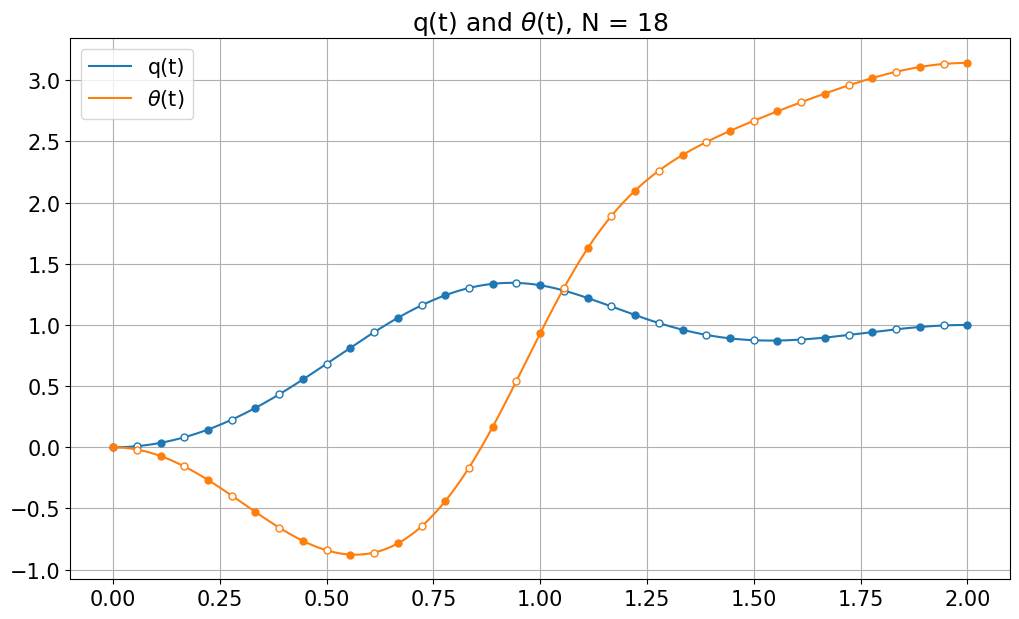

In [163]:
plt.figure(figsize=oct_fig_size)
labels= ['q(t)', r'$\theta$(t)']
for ii in range(2):
    plt.plot(t_interp, q_interp[:,ii], c = f'C{ii}', label = labels[ii])
    plt.plot(_res['t'],_res['q'][:,ii], 'o', c = f'C{ii}', ms =marker_size)
    if 'parab' in scheme: 
        plt.plot(_res['t_c'],_res['q_c'][:,ii],
                 'o', mec = f'C{ii}', ms =marker_size, mfc = 'w',
                # label = labels[ii] + '_c'
                )
#plt.plot(t_ref, q_ref, ':')



#save = True#False#

    
plt.grid()
plt.legend()
plt.title(r'q(t) and $\theta$(t)' + f', N = {n_col}')
plt.tight_layout(pad=0.0)

if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'q',
            schemes_printed = [scheme],
            save_format = save_format,
            N = n_col,
            q_counter = None,
            add = f'model {model} ODE 3 HS{order} cost {cost_f}'
        )
        

Text(0.5, 1.0, 'q and theta difference')

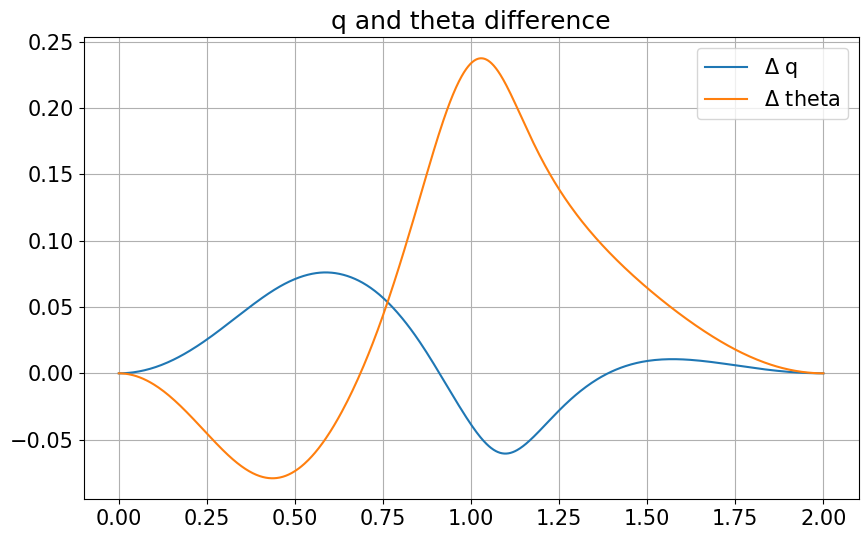

In [164]:
plt.figure(figsize=oct_fig_size)
labels= ['q', 'theta']
for ii in range(2):
    plt.plot(t_interp, q_interp[:,ii]- q_ode_2_interp[:,ii], label = f'$\Delta$ {labels[ii]}')
    #plt.plot(_res['t'],_res['q'][:,ii], 'o', ms =marker_size, label = labels[ii])
    #if 'parab' in scheme: 
    #    plt.plot(_res['t_c'],_res['q_c'][:,ii], 'o', ms =marker_size, label = labels[ii] + '_c')
plt.grid()
plt.legend()
plt.title('q and theta difference')

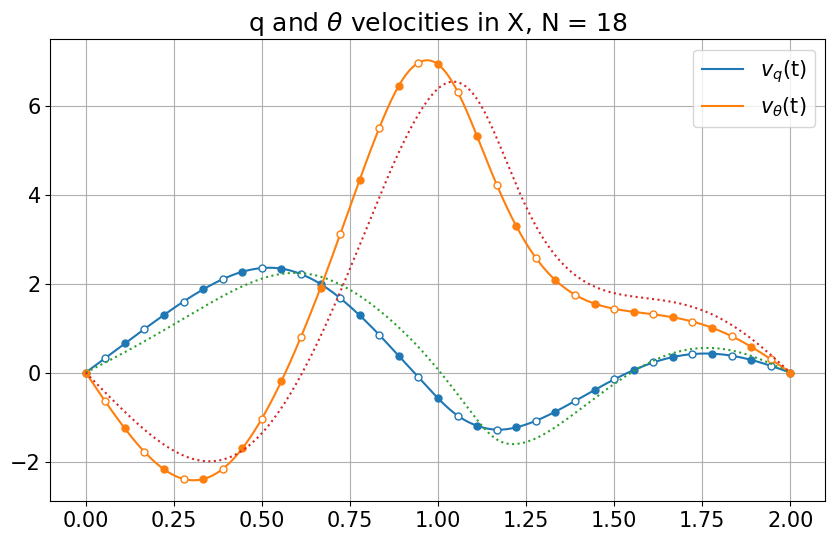

In [165]:
plt.figure(figsize=oct_fig_size)
labels= [r'$v_q$(t)', r'$v_{\theta}$(t)']
for ii in range(2):
    plt.plot(t_interp, v_interp[:,ii], c = f'C{ii}', label = labels[ii])
    plt.plot(_res['t'],_res['v'][:,ii], 'o', c = f'C{ii}', ms =marker_size)
    if 'parab' in scheme:
        plt.plot(_res['t_c'],_res['v_c'][:,ii],
                 'o', mec = f'C{ii}', ms =marker_size, mfc = 'w',
                # , label = labels[ii] + '_c'
                )
plt.plot(t_ref, v_ref, ':')
plt.grid()
plt.legend()
plt.title(r'q and $\theta$ velocities in X'+ f', N = {n_col}')

#save = False#True#
if False:
        save_fig(
            problem_name = problem_name,
            graph_name = 'q_dot',
            schemes_printed = [scheme],
            save_format = 'pdf',
            N = n_col,
            q_counter = None,
            add = f'model {model} ODE 3 HS{order} cost {cost_f}'
        )

Text(0.5, 1.0, 'q and $\\theta$ accelerations in X, N = 18')

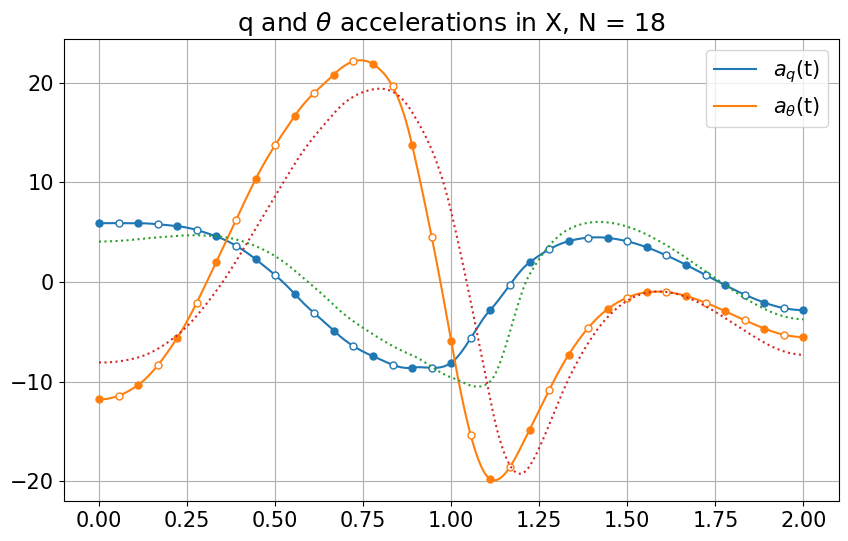

In [166]:
plt.figure(figsize=oct_fig_size)
labels= [r'$a_q$(t)', r'$a_{\theta}$(t)']
for ii in range(2):
    plt.plot(t_interp, a_interp[:,ii], c = f'C{ii}', label = labels[ii])    
    plt.plot(_res['t'],_res_a[:,ii], 'o', c = f'C{ii}', ms =marker_size)
    if 'parab' in scheme:
        plt.plot(_res['t_c'],_res_a_c[:,ii],
                 'o', mec = f'C{ii}', ms =marker_size, mfc = 'w',
                #  label = labels[ii] + '_c'
                )
plt.plot(t_ref, a_ref, ':')
#plt.plot(t_interp, a_from_dyn, ':')
plt.grid()
plt.legend()
plt.title(r'q and $\theta$ accelerations in X'+ f', N = {n_col}')
#plt.xlim((1,1.25))

Text(0.5, 1.0, 'q and $\\theta$ Jerk in $ \\dot{X} $, N = 18')

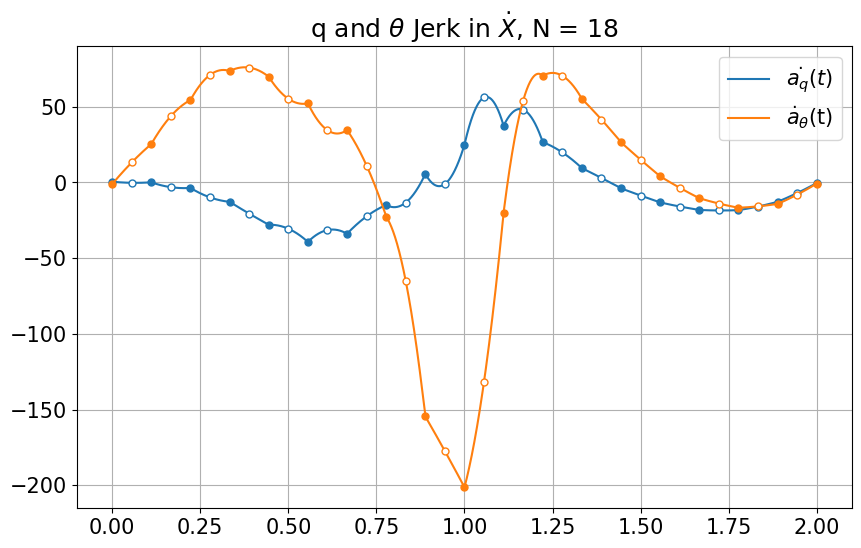

In [167]:
plt.figure(figsize=oct_fig_size)
labels= [r'$\dot{a_q}(t)$', r'$\dot{a}_{\theta}$(t)']
for ii in range(2):
    plt.plot(t_interp, j_interp[:,ii], c = f'C{ii}', label = labels[ii])
    plt.plot(_res['t'],_res_j[:,ii],  'o', c = f'C{ii}', ms =marker_size)
    if 'parab' in scheme:
        plt.plot(_res['t_c'],_res_j_c[:,ii],
                 'o', mec = f'C{ii}', ms =marker_size, mfc = 'w',
                #  label = labels[ii] + '_c'
                )
#plt.plot(t_ref, j_ref, ':')
#plt.plot(t_ode_2, j_ode_2, ':')
plt.grid()
plt.legend()
plt.title(r'q and $\theta$ Jerk in $ \dot{X} $'+ f', N = {n_col}')

In [168]:
_res['x_d'][0, -3:-1]

array([-11.78123447,   0.52370352])

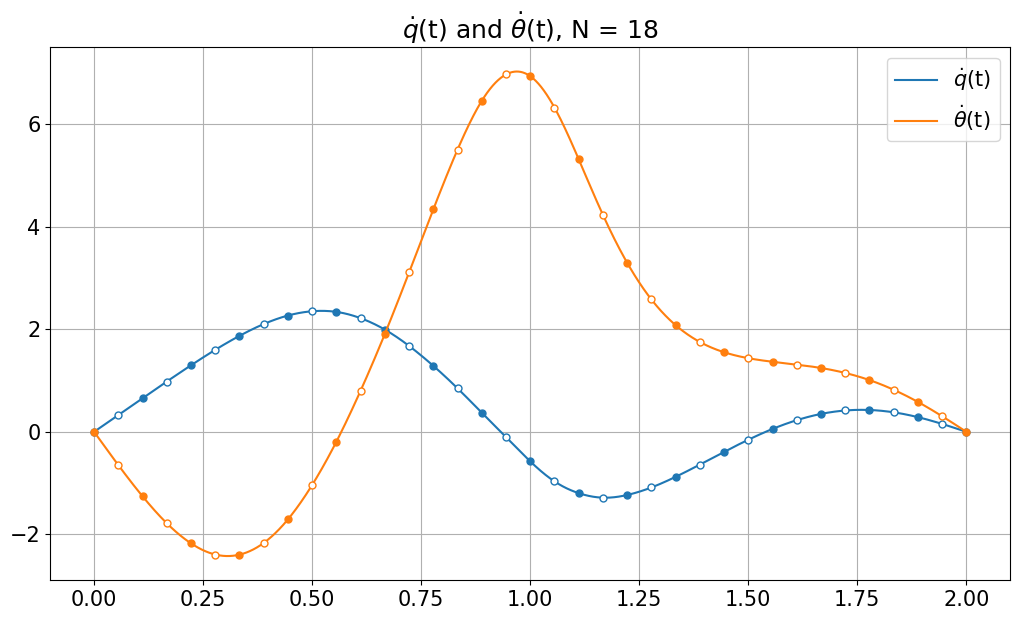

In [169]:
plt.figure(figsize=oct_fig_size)
labels= [r'$\dot{q}$(t)', r'$\dot{\theta}$(t)']
for ii in range(2):
    plt.plot(t_interp, q_d_interp[:,ii], c = f'C{ii}', label = labels[ii])
    plt.plot(_res['t'],_res['v'][:,ii], 'o', c = f'C{ii}', ms =marker_size)
    if 'parab' in scheme: 
        plt.plot(_res['t_c'],_res['v_c'][:,ii],
                 'o', mec = f'C{ii}', ms =marker_size, mfc = 'w',
                #  label = labels[ii] + '_c'
                )
       

    
    
#plt.plot(t_ref, v_ref, ':')
plt.grid()
plt.legend()
plt.title(r'$\dot{q}$(t) and $\dot{\theta}$(t)'+ f', N = {n_col}')
plt.tight_layout(pad=0.0)

#save = True#False#
if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'q_dot',
            schemes_printed = [scheme],
            save_format = save_format,
            N = n_col,
            q_counter = None,
            add = f'model {model} ODE 3 HS{order} cost {cost_f}'
        )

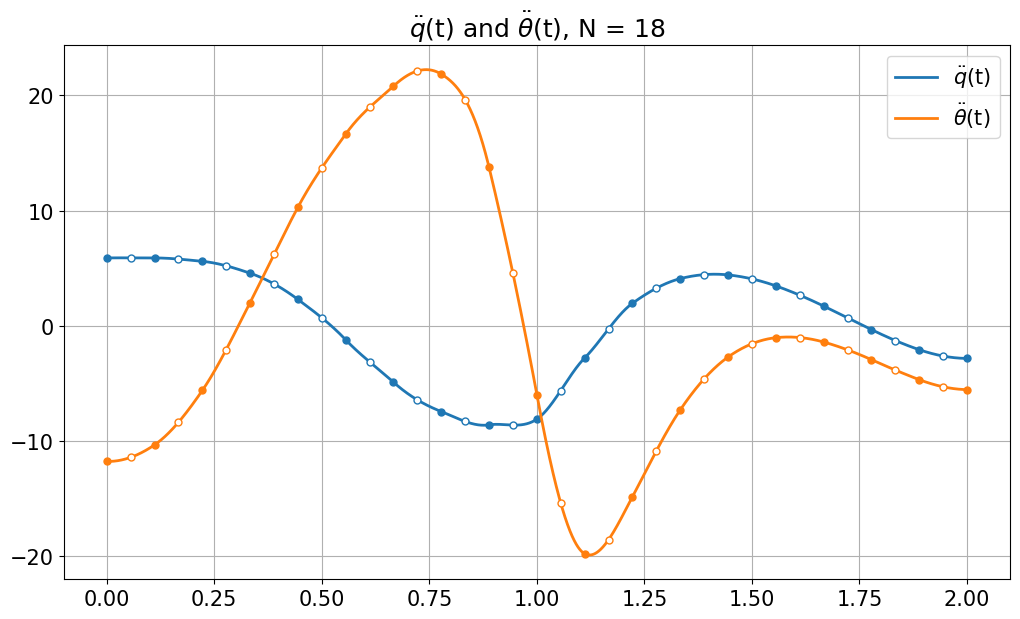

In [170]:
plt.figure(figsize=oct_fig_size)
labels= [r'$\ddot{q}$(t)', r'$\ddot{\theta}$(t)']
for ii in range(2):
    plot_by_segments(
        t_arr = t_interp,
        y_plot = q_dd_interp[:,ii],
        label = labels[ii],
        N = n_col,
        end_t = 2,
        plot_dict = {
            'c': f'C{ii}',
            'lw':2,
        }
    )
    if False:
        for kk in range(len(jerk_impulses)):
            plt.arrow(
                _res['t'][1+kk],
                slope_pos[kk,ii],
                0,
                jerk_impulses[kk,ii],
                color = 'w',
                width = 0.01,
                length_includes_head=True,
                head_length = 0.4*abs(jerk_impulses[kk,ii]),
                ec = f'C{ii}'
            )
    #plt.plot(t_interp, q_dd_interp[:,ii], c = 'grey')
    if order == 3:
        plt.plot(
            _res['t'],_res_a[:,ii], 'o', ms =marker_size, c = f'C{ii}',
            #label = labels[ii]
        )
        if 'parab' in scheme: 
            plt.plot(_res['t_c'],_res_a_c[:,ii],
                     'o', mec = f'C{ii}', ms =marker_size, mfc = 'w',
                     #label = labels[ii] + '_c'
                    )




#plt.plot(t_ref, a_ref, ':', c='k', label = 'HS3 ref sol')
plt.grid()
plt.legend()
plt.title(r'$\ddot{q}$(t) and $\ddot{\theta}$(t)'+ f', N = {n_col}')
plt.tight_layout(pad=0.0)

#save = True#False#
if save:
    save_fig(
        problem_name = problem_name,
        graph_name = 'q_dot_dot',
        schemes_printed = [scheme],
        save_format = save_format,
        N = n_col,
        q_counter = None,
        add = f'model {model} ODE 3 HS{order} cost {cost_f}'
    )

In [171]:
jerk_scale = np.max(q_ddd_interp[:,:2]) - np.min(q_ddd_interp[:,:2])
impulse_scale = np.max(np.abs(jerk_impulses))
scale_factor = 0.2 * jerk_scale/impulse_scale
jerk_scale, impulse_scale

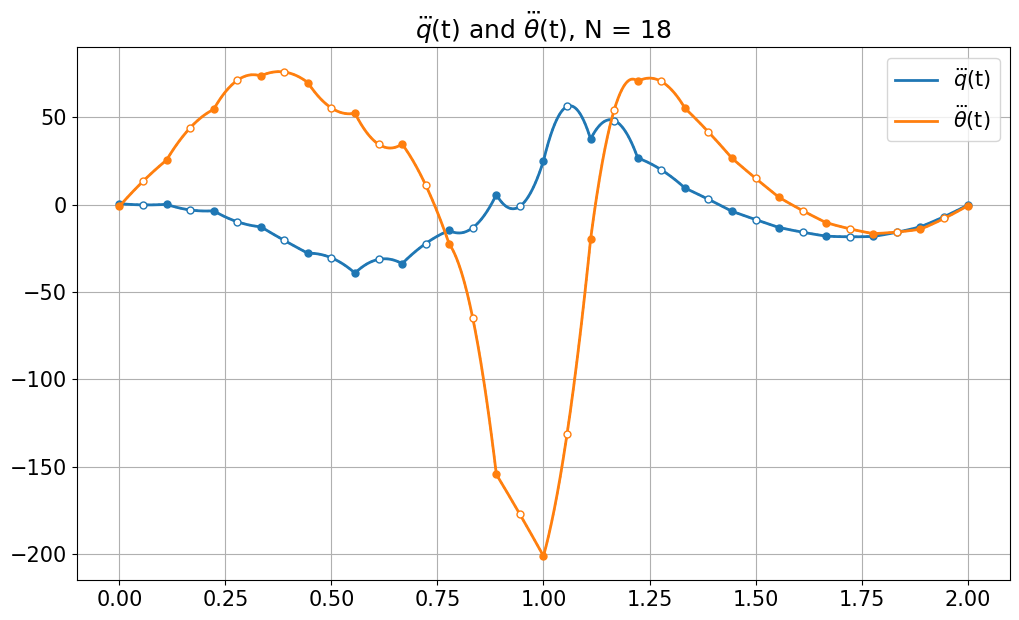

In [172]:
plt.figure(figsize=oct_fig_size)
labels= [r'$\dddot{q}$(t)', r'$\dddot{\theta}$(t)']
for ii in range(2):
    #plt.plot(t_interp, q_ddd_interp[:,ii], c = 'grey')
    plot_by_segments(
        t_arr = t_interp,
        y_plot = q_ddd_interp[:,ii],
        label = labels[ii],
        N = n_col,
        end_t = 2,
        plot_dict = {
            'c': f'C{ii}',
            'lw':2,
        }
    )
    
    if False:
        for kk in range(len(jerk_impulses)):
            plt.arrow(
                _res['t'][1+kk],
                jerk_heights[kk,ii],
                0,
                scale_factor*jerk_impulses[kk,ii],
                color = 'w',
                width = 0.01,
                length_includes_head=True,
                head_length = scale_factor*0.4*abs(jerk_impulses[kk,ii]),
                ec = f'C{ii}'
            )
        
    plt.plot(t_interp, q_ddd_interp[:,ii], c = f'C{ii}', ls= ':')
    
    if order == 3:
        plt.plot(
            _res['t'],_res_j[:,ii], 'o', ms =marker_size, c = f'C{ii}',
            #label = labels[ii]
        )
        if 'parab' in scheme: 
            plt.plot(_res['t_c'],_res_j_c[:,ii],
                     'o', mec = f'C{ii}', ms =marker_size, mfc = 'w',
                     #label = labels[ii] + '_c'
                    )


        
#plt.plot(t_ref, j_ref, ':')
plt.grid()
plt.legend()
plt.title(r'$\dddot{q}$(t) and $\dddot{\theta}$(t)'+ f', N = {n_col}')
plt.tight_layout(pad=0.0)

#save = True#False#
if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'q_dot_dot_dot',
            schemes_printed = [scheme],
            save_format = save_format,
            N = n_col,
            q_counter = None,
            add = f'model {model} ODE 3 HS{order} cost {cost_f}'
        )

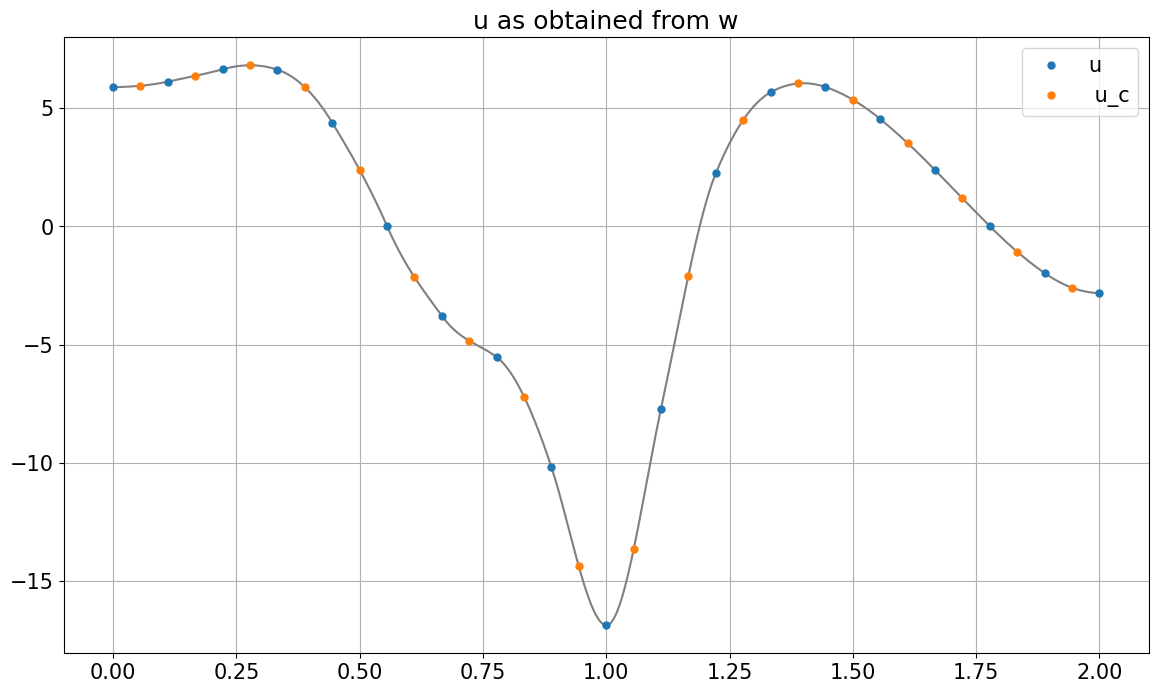

In [84]:
plt.figure(figsize=oct_fig_size)
plt.plot(t_interp, u_interp, c = 'grey')
plt.plot(_res['t'],_res_u, 'o', ms =marker_size, label = 'u')
if 'parab' in scheme:
    plt.plot(_res['t_c'],_res_u_c,  'o', ms =marker_size, label = ' u_c')
#plt.plot(tt_in, uu_in, '--')
u_dyn = u_expr_np(q_interp, v_interp, a_interp, params)
#plt.plot(t_interp, u_dyn, c = 'red', ls = ':', label = 'u from dynamics')
plt.grid()
plt.legend()

if model in ['u_in_x']:
    plt.title('u as component of X')
else:
    plt.title('u as obtained from w')


plt.tight_layout(pad=0.0)
#save = True#False#
if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'u',
            schemes_printed = [scheme],
            save_format = 'png',
            N = n_col,
            q_counter = None,
            add = f'model {model} ODE 3 HS{order} cost {cost_f}'
        )

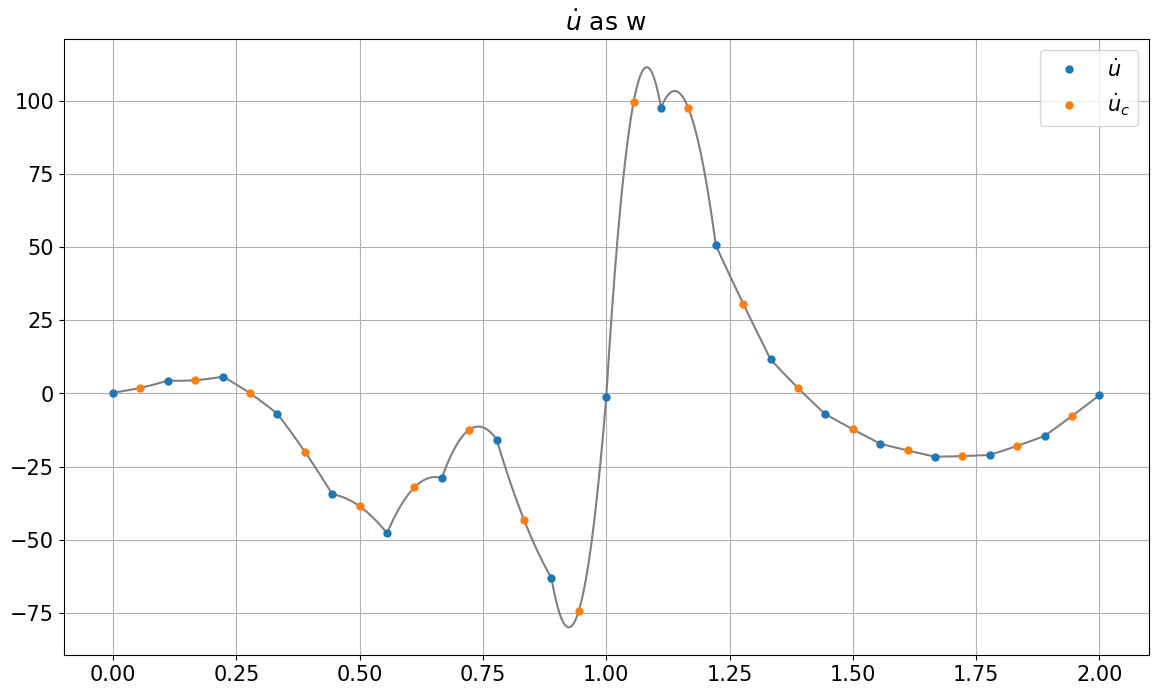

In [83]:
plt.figure(figsize=oct_fig_size)
plt.plot(t_interp, w_interp, c = 'grey')
plt.plot(_res['t'],_res['u'],  'o', ms =marker_size, label = r'$\dot{u}$')
if 'parab' in scheme:
    plt.plot(_res['t_c'],_res['u_c'],  'o', ms =marker_size, label = r'$\dot{u}_c$')
plt.grid()
plt.legend()
plt.title(r'$\dot{u}$ as w')

plt.tight_layout(pad=0.0)
#save = True#False#
if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'u_dot',
            schemes_printed = [scheme],
            save_format = 'png',
            N = n_col,
            q_counter = None,
            add = f'model {model} ODE 3 HS{order} cost {cost_f}'
        )

## Sistematic comparison of schemes for different values of N

Now let's solve the problem with different methods.

### Caution!

Executing the next cell may require some time!

In [591]:
model =  'impl_diff'#'u_in_x'#
cost_f =  'u_dot'#'j'#


schemes = [
    #'LG2',
    'hsn_parab',
    #'hs_parab',
    'trapz_n',
    #'trapz',
    'LG',
    'LGR',
    'LGL',
    #'CG',
    'BU_LG',
    'BU_LGR',
    'BU_LGL',
    #'BU_CG',
    'TD_LG',
    'TD_LGR',
    'TD_LGL',
    #'TD_CG',
] #If you defined a custom function, name your scheme here
initials = ['lin']
solve_repetitions = 2 #Increase this number to get more reliable values of execution times
N_arr = [
    5, 7, 10, 12,
    15, 20, 25, 30, 35, 40, 45, 50,
    #60, 80, 100,
    #120, 160, 200,
    #110, 120, 125, 130, 140, 150, 160, 170, 175, 180, 190, 200, 220, 225, 240, 250, 260, 275,
    #280, 300,]# 325, 350, 375, 400,]# 425, 450, 475, 500, 525, 550, 575, 600
]# You can increase the numbers here, but it will take more time
#N_arr = [50, 60,]
results = {}

for scheme in schemes:
        for order in [1,3]:
            if scheme == 'LG2' and order != 2:
                continue
            if scheme in ['LG', 'LGL', 'LGR', 'CG', 'CGL', 'CGR'] and order != 1:
                continue
            key = scheme + f'_{order}'
            results[key] = {'N_arr':N_arr}
            results[key]['scheme'] = scheme
            results[key]['order'] = order
            
for N in N_arr:
    print(f'\tN = {N}')
    for scheme in schemes:
        for order in [1,3]:
            if scheme == 'LG2' and order != 2:
                continue
            if scheme in ['LG', 'LGL', 'LGR', 'CG', 'CGL', 'CGR'] and order != 1:
                continue
            key = scheme + f'_{order}'
            print(f'Problem: {key}, ', time.strftime('%H:%M:%S ', time.localtime(time.time())))
            try:
                results[key][N] =  casadi_cartpole_derivated(
                    scheme,
                    N,
                    'lin',
                    solve_repetitions=solve_repetitions,
                    order = order,
                    cost_f = cost_f,
                    u_parab = False,
                    model = model,
                    silent=True,
                    verbose=False
                )
            except RuntimeError: 
                results[key][N] = None
                print('ATTEMPT FAILED!!')
                results[key][N] = copy(casadi_cartpole_derivated(
                    'hs_parab',
                    20, 
                    'lin',
                    solve_repetitions=solve_repetitions,
                    order = 1,
                    cost_f = cost_f,
                    u_parab = False,
                    model = model,
                    silent=True, 
                    verbose=False))
                for item in results[key][N]:
                    try:
                        results[key][N][item] = results[key][N][item]*np.nan
                    except TypeError:
                        results[key][N][item] = np.nan
        


	N = 5
Problem: hsn_parab_1,  16:52:00 
Problem: hsn_parab_3,  16:52:01 
Problem: trapz_n_1,  16:52:01 
Problem: trapz_n_3,  16:52:01 
Problem: LG_1,  16:52:01 
Problem: LGR_1,  16:52:01 
Problem: LGL_1,  16:52:01 
ATTEMPT FAILED!!


CasADi - 2024-10-10 16:52:01 WARNING("NLP is overconstrained: There are 69 equality constraints but only 65 variables.") [.../casadi/core/nlpsol.cpp:512]


Problem: BU_LG_1,  16:52:01 
Problem: BU_LG_3,  16:52:01 
Problem: BU_LGR_1,  16:52:01 
Problem: BU_LGR_3,  16:52:01 
Problem: BU_LGL_1,  16:52:01 
Problem: BU_LGL_3,  16:52:01 
Problem: TD_LG_1,  16:52:01 
Problem: TD_LG_3,  16:52:01 
Problem: TD_LGR_1,  16:52:01 
Problem: TD_LGR_3,  16:52:01 
Problem: TD_LGL_1,  16:52:01 
Problem: TD_LGL_3,  16:52:01 
	N = 7
Problem: hsn_parab_1,  16:52:01 
Problem: hsn_parab_3,  16:52:02 
Problem: trapz_n_1,  16:52:02 
Problem: trapz_n_3,  16:52:02 
Problem: LG_1,  16:52:02 
Problem: LGR_1,  16:52:02 
Problem: LGL_1,  16:52:02 
ATTEMPT FAILED!!
Problem: BU_LG_1,  16:52:02 
Problem: BU_LG_3,  16:52:02 
Problem: BU_LGR_1,  16:52:02 
Problem: BU_LGR_3,  16:52:02 
Problem: BU_LGL_1,  16:52:02 
Problem: BU_LGL_3,  16:52:02 
Problem: TD_LG_1,  16:52:02 


CasADi - 2024-10-10 16:52:02 WARNING("NLP is overconstrained: There are 93 equality constraints but only 91 variables.") [.../casadi/core/nlpsol.cpp:512]


Problem: TD_LG_3,  16:52:02 
Problem: TD_LGR_1,  16:52:02 
Problem: TD_LGR_3,  16:52:02 
Problem: TD_LGL_1,  16:52:02 
Problem: TD_LGL_3,  16:52:02 
	N = 10
Problem: hsn_parab_1,  16:52:02 
Problem: hsn_parab_3,  16:52:02 
Problem: trapz_n_1,  16:52:02 
Problem: trapz_n_3,  16:52:03 
Problem: LG_1,  16:52:03 
Problem: LGR_1,  16:52:03 
Problem: LGL_1,  16:52:03 
ATTEMPT FAILED!!
Problem: BU_LG_1,  16:52:03 
Problem: BU_LG_3,  16:52:03 
Problem: BU_LGR_1,  16:52:03 
Problem: BU_LGR_3,  16:52:03 
Problem: BU_LGL_1,  16:52:03 
Problem: BU_LGL_3,  16:52:03 
Problem: TD_LG_1,  16:52:03 
Problem: TD_LG_3,  16:52:03 
Problem: TD_LGR_1,  16:52:03 
Problem: TD_LGR_3,  16:52:03 
Problem: TD_LGL_1,  16:52:03 
Problem: TD_LGL_3,  16:52:03 
	N = 12
Problem: hsn_parab_1,  16:52:03 
Problem: hsn_parab_3,  16:52:03 
Problem: trapz_n_1,  16:52:04 
Problem: trapz_n_3,  16:52:04 
Problem: LG_1,  16:52:04 
Problem: LGR_1,  16:52:04 
Problem: LGL_1,  16:52:04 
ATTEMPT FAILED!!
Problem: BU_LG_1,  16:52:04 


In [592]:
for key in results.keys():
        _c = []
        _cpudt = []
        _iters = []
        for N in results[key]['N_arr']:
            _c.append(results[key][N]['cost'])
            _cpudt.append(results[key][N]['cpudt'])
            _iters.append(results[key][N]['iter_count'])
        results[key]['cost'] = np.array(_c)
        results[key]['cpudt'] = np.array(_cpudt)
        results[key]['iter_count'] = np.array(_iters)

Text(0.5, 1.0, 'Final traj cost')

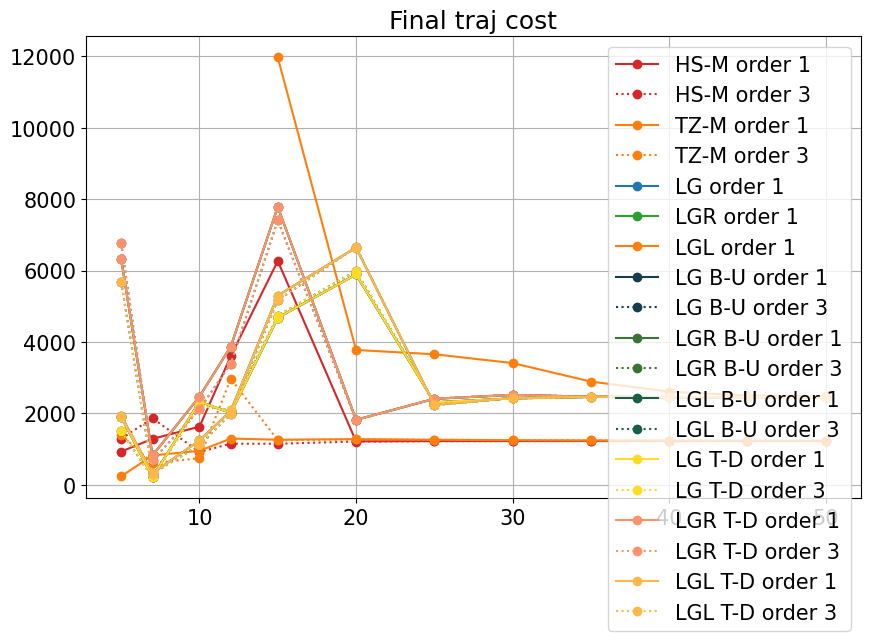

In [593]:
plt.figure(figsize=oct_fig_size)
for key in results.keys():
    scheme = results[key]['scheme']
    plot_kw = scheme_kwargs(scheme, longlabel=False)
    plot_kw['ls'] = '-' if results[key]['order'] == 1 else ':'
    plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
    plt.plot(results[key]['N_arr'], results[key]['cost'][:], **plot_kw)
#plt.yscale('log')
plt.grid()
plt.legend()
plt.title('Final traj cost')

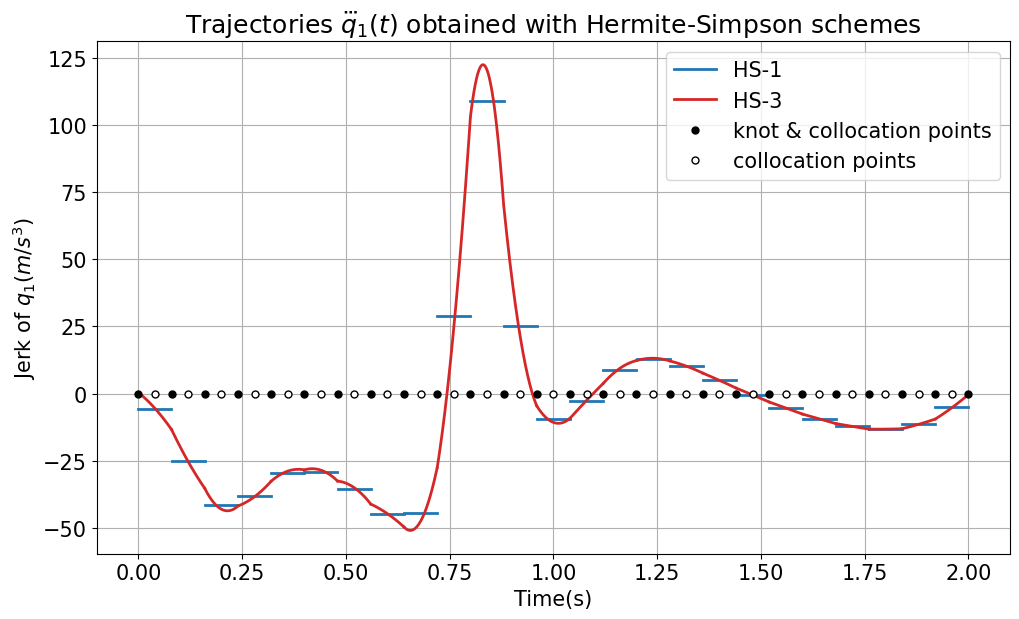

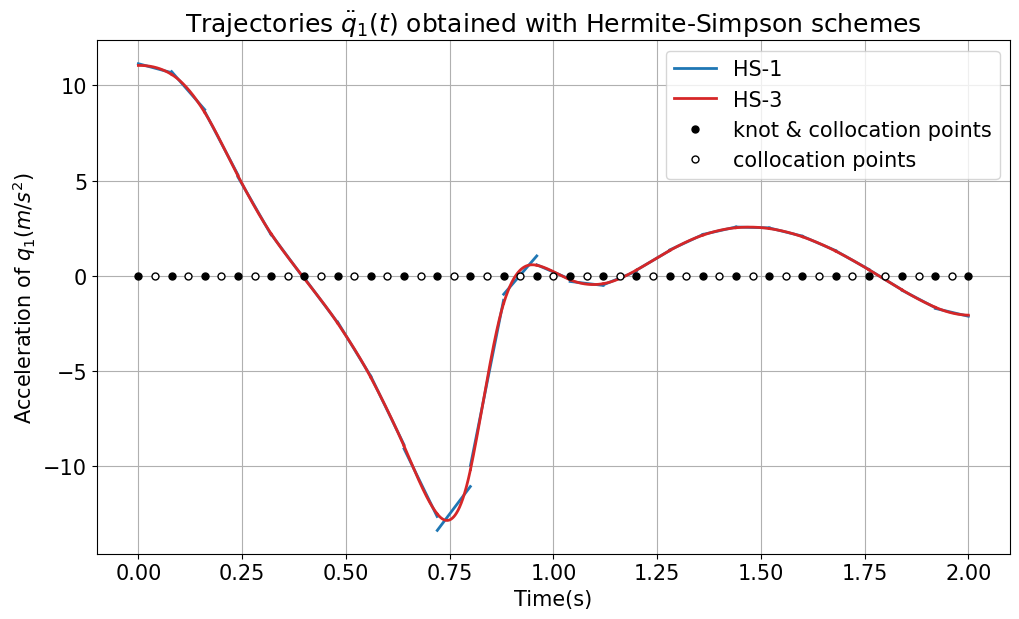

In [594]:
plot_n = 5000
t_interp = np.linspace(0, 2, plot_n)
marker_size = 5
N = 25
dt = (_res['t'][-1]-_res['t'][0])/N

#HS1

_res = results['hsn_parab_1'][N]
u_scheme = 'parab'
sch_param = {
    'u_c':_res['u_c'],
    "x_dot_c":_res['x_d_c'],
    "order":3}

q_dd_interp_hs1 = interpolated_array_derivative(
    X = _res['x'],
    U = _res['u'],
    h = dt,
    t_array = t_interp,
    params = params,
    F=F_nump_w,
    X_dot=_res['x_d'],
    scheme= 'hs_parab',
    order=2,
    scheme_params=sch_param,)[:, :3]

q_ddd_interp_hs1 = interpolated_array_derivative(
    X = _res['x'],
    U = _res['u'],
    h = dt,
    t_array = t_interp,
    params = params,
    F=F_nump_w,
    X_dot=_res['x_d'],
    scheme= 'hs_parab',
    order=3,
    scheme_params=sch_param,)[:, :3]

#HS3

_res = results['hsn_parab_3'][N]
u_scheme = 'parab'
sch_param = {
    'u_c':_res['u_c'],
    "x_dot_c":_res['x_d_c'],
    "order":3}

q_dd_interp_hs3 = interpolated_array_derivative(
    X = _res['x'],
    U = _res['u'],
    h = dt,
    t_array = t_interp,
    params = params,
    F=F_nump_w,
    X_dot=_res['x_d'],
    scheme= 'hsn_parab',
    order=2,
    scheme_params=sch_param,)[:, :3]

q_ddd_interp_hs3 = interpolated_array_derivative(
    X = _res['x'],
    U = _res['u'],
    h = dt,
    t_array = t_interp,
    params = params,
    F=F_nump_w,
    X_dot=_res['x_d'],
    scheme= 'hsn_parab',
    order=3,
    scheme_params=sch_param,)[:, :3]


schemes_label = ['HS-1', 'HS-3']
schemes_plot = ['hs', 'hsn']
y_plot_list = [q_ddd_interp_hs1[:,0], q_ddd_interp_hs3[:,0]]
y_plot_list_2 = [q_dd_interp_hs1[:,0], q_dd_interp_hs3[:,0]]
plots = [y_plot_list, y_plot_list_2]
y_labels = ["Jerk of $q_1 (m/s^3)$","Acceleration of $q_1 (m/s^2)$"]
_dd = ["ddd", "dd"]

for kk in range(2):
    plt.figure(figsize=oct_fig_size)
    plot_coll_p = False
    for ii in range(2):

        t_arr = t_interp
        interv_n = (N * t_arr) / _res["t"][-1]
        cut_p = 0
        y_plot = plots[kk][ii]
        scheme = schemes_plot[ii]
        label = schemes_label[ii]
        name = label.replace('HS', 'Hermite-Simpson')
        for ll in range(1, N + 1):
            jj = np.searchsorted(interv_n, ll)
            plt.plot(
                t_arr[cut_p:jj],
                y_plot[cut_p:jj],
                "-",
                lw=2,
                c=sch_to_color(scheme),
                label=label if cut_p == 0 else None,
            )
            cut_p = jj
    if "hs" in scheme:
        plot_coll_p = True
    plt.plot(
        _res["t"],
        np.zeros(N + 1),
        "ok",
        ms=5,
        label="knot & collocation points",
    )
    if plot_coll_p:
        plt.plot(
            _res["t_c"],
            np.zeros(N),
            "ow",
            ms=5,
            markeredgecolor="k",
            label="collocation points",
        )
    plt.legend()
    plt.grid()
    # plt.ylim([-0.01,y_max_list[ii]])
    plt.title(f"Trajectories $\{_dd[kk]}"+"ot{q}_1(t)$ obtained with Hermite-Simpson schemes")
    plt.xlabel("Time(s)")
    plt.ylabel(y_labels[kk])
    plt.tight_layout(pad=0.0)
    
    
    save = False
    if save:
        save_fig(
            problem_name = problem_name,
            graph_name = f'q{_dd[kk]}',
            schemes_printed = schemes,
            save_format = 'pdf',
            N = N,
            q_counter = component,
        )

N = 60
scheme = 'BU_LG'
plt.figure(figsize=[14,8])

for ii in range(1,3):
    key = scheme + f'_{ii}'
    uu_pol, q_n_der_pols = chords.bu_pseudospectral.Polynomial_interpolations_BU(
        results[key][N]['x_d'],
        results[key][N]['x'][0,:],
        results[key][N]['u'],
        scheme,
        ii,
        0,
        2,
        N
    )
    

    plt.plot(results[key][N]['t_col'],results[key][N]['u'][:], 'o', label = 'u ' + key)
    plt.plot(t_interp_arr, uu_pol(t_interp_arr), 'grey',':')
plt.grid()
plt.legend()
points_ii = np.array([0, 12, 27, 33, 59])
uu_in = results[key][N]['u'][points_ii]
tt_in = results[key][N]['t_col'][points_ii]
plt.plot(tt_in,uu_in, '-', label = 'u interp')

## Dynamic Error

Now we can compute the dynamic errors for each case

In [595]:
def total_state_error(t_arr, dyn_err):
    errors = np.trapz(np.abs(dyn_err), t_arr, axis=0)
    return errors

In [596]:
import chords
import importlib
importlib.reload(chords.td_pseudospectral)
importlib.reload(chords.util)
importlib.reload(chords.pseudospectral)
importlib.reload(chords.analysis)
importlib.reload(chords)
from chords.util import sch_to_color, sch_to_lab, scheme_kwargs

from chords.td_pseudospectral import dynamic_error_TD, interpolations_deriv_TD_pseudospectral

In [597]:
from chords.analysis import dynamic_errors

In [598]:
results.keys()

dict_keys(['hsn_parab_1', 'hsn_parab_3', 'trapz_n_1', 'trapz_n_3', 'LG_1', 'LGR_1', 'LGL_1', 'BU_LG_1', 'BU_LG_3', 'BU_LGR_1', 'BU_LGR_3', 'BU_LGL_1', 'BU_LGL_3', 'TD_LG_1', 'TD_LG_3', 'TD_LGR_1', 'TD_LGR_3', 'TD_LGL_1', 'TD_LGL_3'])

In [599]:
n_interp = 2000
if model == 'u_in_x':
    f_expl = F_nump_w
elif model == 'impl_diff':
    f_expl = F_nump_w_alt
else:
    raise ValueError()
    
    
for key in results.keys():
    scheme = results[key]['scheme'] 
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    for N in N_arr:
        print(f'\tN = {N}')
        res = results[key][N]
        if res['scheme'] is np.nan:
            print('\t\tNaN in Scheme')
            nan_arr = np.zeros([n_interp, 3])*np.nan
            errors= {
                'compat_err_1_interp': nan_arr,
                'dyn_err_interp' : nan_arr,
            }
            res['error'] = errors
        else:
            errors = dynamic_errors(
                res,
                f_expl,
                dynamics_error_mode = 'q',
                problem_order=3,
                scheme_order=3,
                x_interp=None,
                u_interp=None,
                n_interp=n_interp,
            )
        dyn_err_q = errors['compat_err_1_interp']
        dyn_err_3 = errors['dyn_err_interp']
        t_arr = np.linspace(0,2, n_interp)
        tot_dyn_err_q = total_state_error(t_arr, dyn_err_q)
        tot_dyn_err_3 = total_state_error(t_arr, dyn_err_3)
        errors['err_q'] = tot_dyn_err_q
        errors['err_3'] = tot_dyn_err_3
            

Problem: hsn_parab_1
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
	N = 30
	N = 35
	N = 40
	N = 45
	N = 50
Problem: hsn_parab_3
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
	N = 30
	N = 35
	N = 40
	N = 45
	N = 50
Problem: trapz_n_1
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
	N = 30
	N = 35
	N = 40
	N = 45
	N = 50
Problem: trapz_n_3
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
	N = 30
	N = 35
	N = 40
	N = 45
	N = 50
Problem: LG_1
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
	N = 30
	N = 35
	N = 40
	N = 45
	N = 50
Problem: LGR_1
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
	N = 30
	N = 35
	N = 40
	N = 45
	N = 50
Problem: LGL_1
	N = 5
		NaN in Scheme
	N = 7
		NaN in Scheme
	N = 10
		NaN in Scheme
	N = 12
		NaN in Scheme
	N = 15
	N = 20
	N = 25
	N = 30
	N = 35
	N = 40
	N = 45
	N = 50
Problem: BU_LG_1
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
	N = 30
	N = 35
	N = 40
	N = 45
	N = 50
Problem: BU_LG_3
	N = 5
	N = 7
	N = 10
	N =

In [600]:
def arr_mod(x):
    x_1 = np.sum(x*x, axis=1)
    return np.sqrt(x_1)
def arr_sum(x):
    return np.sum(np.abs(x), axis = 1)
def arr_max(x):
    return np.max(np.abs(x), axis = 1)

In [602]:
for key in results.keys():
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    err_q_acum = []
    err_3_acum = []
    cpudt = []
    for N in N_arr:
        errors = results[key][N]['error']
        err_q_acum.append(errors['err_q'])
        err_3_acum.append(errors['err_3'])
    results[key]['err_q_acum'] = np.array(err_q_acum, dtype = float)
    results[key]['err_3_acum'] = np.array(err_3_acum, dtype = float)
    

Problem: hsn_parab_1
Problem: hsn_parab_3
Problem: trapz_n_1
Problem: trapz_n_3
Problem: LG_1
Problem: LGR_1
Problem: LGL_1


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (12,) + inhomogeneous part.

In [603]:
err_q_acum

[array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([6.02154185e-39, 0.00000000e+00]),
 array([1.83762874e-43, 0.00000000e+00]),
 array([0.00000000e+00, 9.40865914e-40]),
 array([2.11694831e-40, 3.01077092e-38]),
 array([2.17501622e-28, 1.75081993e-25]),
 array([2.72934076e-28, 7.58836163e-27]),
 array([6.53049489e-23, 1.13762185e-20]),
 array([3.85253513e-33, 6.76572708e-30])]

for key in results.keys():
    scheme = results[key]['scheme']
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    for N in N_arr:
        print(f'\tN = {N}')
        _case = results[key][N]
        t_arr = np.linspace(0,
                        _case['t'][-1],
                        _case['dyn_err_2'].shape[0])
            
        _derivs = interpolations_deriv_TD_pseudospectral(
            _case['q_constr'],
            _case['x'],
            _case['x_d'],
            scheme,
            deriv_order = 1,
            t0 = 0,
            tf = _case['t'][-1],
            n_coll=_case['u'].shape[0],
            scheme_order = 2,
            x_interp="pol",
            n_interp=n_interp,
        )
        _accels = _derivs[:, 2:]
        
        #_case[f'sum_dyn_err_2_arr'] = arr_sum(_case['dyn_err_2']) # NOT VALID
        _case[f'sum_dyn_err_2_arr'] = None
        _case['a_arr'] = _accels
        _case['a_abs_mean_by_component'] = np.mean(np.abs(_accels), axis = 0)
        _case['a_abs_mean'] = np.mean(np.abs(_accels))
        #_case['a_abs_sum_arr'] = arr_sum(_accels) # NOT VALID
        _case['a_abs_sum_arr'] = None
        
        _case['rel_dyn_err_2_arr_by_instant_a_sum'] = arr_sum(_case['dyn_err_2']/_case['a_arr'])
        _case['rel_dyn_err_2_arr_by_total_mean_sum'] = None
        _case['rel_dyn_err_2_arr_by_mean_by_component_sum'] = arr_sum(_case['dyn_err_2']/_case['a_abs_mean_by_component'])
        _case['rel_dyn_err_2_arr_by_a_sum_arr_sum'] = None

def plot_by_segments(results, schemes, N, thing_to_plot, title, ylabel, component = 'all'):
    plt.figure(figsize=oct_fig_size)
    plot_coll_p = False
    for scheme in schemes:
        t_arr = np.linspace(0,
                        results[scheme][N]['t'][-1],
                        results[scheme][N][thing_to_plot].shape[0])
        interv_n = (N * t_arr)/results[scheme][N]['t'][-1]
        cut_p = 0
        for ll in range(1,N+1):
            jj = np.searchsorted(interv_n, ll)
            y_plot = results[scheme][N][thing_to_plot]
            if component != 'all':
                y_plot = y_plot[:, component]
            plt.plot(
                t_arr[cut_p:jj],
                y_plot[cut_p:jj],
                '-', c = sch_to_color(scheme),
                label = sch_to_lab(scheme) if cut_p == 0 else None)
            cut_p = jj
        if 'hs' in scheme:
            plot_coll_p = True
    plt.plot(results[scheme][N]['t'], np.zeros(N+1), 'ok', ms=5, label = 'knot & collocation points')
    if plot_coll_p:
        plt.plot(results[scheme][N]['t_c'], 
                     np.zeros(N), 'ow', ms=5, markeredgecolor='k',
                     label = 'collocation points')
    plt.legend()
    plt.grid()
    #plt.ylim([-0.01,y_max_list[ii]])
    plt.title(title)
    plt.xlabel('Time(s)')
    plt.ylabel(ylabel)
    plt.tight_layout(pad = 0.0)
    #plt.yscale('log')
    #plt.savefig(f'2d_order/5_link_HS_N{N}_second_order_dynamic_error.pdf', format='pdf')

In [ ]:
from chords.util import graph_by_segments

sch = [['hs_parab','hs_mod_parab'],['trapz', 'trapz_mod']]
tit = [['Hermite Simpson','2nd order Hermite Simpson'],['Trapezoidal', '2nd order Trapezoidal']]
colors = [f'C{ii}' for ii in [1,0,2,3]]
n_int = len(t_arr)
N_hh = [25,50]
for hh in range(2):
    schemes = sch[hh]
    titles = tit[hh]
    N = N_hh[hh]
    interv_n = (N * t_arr)/2
    for ii in range(2):
        plt.figure(figsize=oct_fig_size)
        for kk in range(len(schemes)):
            scheme = schemes[kk]
            key = scheme + '_lin'
            cut_p = 0
            for ll in range(1,N+1):
                jj = np.searchsorted(interv_n, ll)
                plt.plot(t_arr[cut_p:jj],results[key][N]['err_q_int'][cut_p:jj,ii], '-', c = colors[2*hh+kk], label = titles[kk] if cut_p == 0 else None)
                cut_p = jj
        plt.plot(np.linspace(0,2,N+1), np.zeros(N+1), 'ok', label = 'knot & collocation points')
        if hh == 0:
            plt.plot(np.linspace(0,2,2*N+1)[1::2], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
        plt.legend()
        plt.grid()
        plt.title(r'First order dynamic error $\varepsilon^{[1]}_{q_'+f'{ii+1}}}$, {titles[0]} schemes, N = {N}')
        plt.xlabel('Time(s)')
        units = 'm/s' if ii == 0 else'rad/s'
        plt.ylabel(f'Dynamic error $({units})$')
        plt.tight_layout(pad = 0.0)
        sch_type = titles[0].replace(' ','_')
        
        # If you are running the notebook locally and want to save the plots,
        # uncomment the next line
        #plt.savefig(f'Cartpole_First_Order_Dynamic_Error_q_{ii+1}_{sch_type}_schemes_N_{N}.eps', format='eps')

In [ ]:
results[key][N].keys()

sch = [['hs_parab','hs_mod_parab'],['trapz', 'trapz_mod']]
tit = [['Hermite Simpson','2nd order Hermite Simpson'],['Trapezoidal', '2nd order Trapezoidal']]
colors = [f'C{ii}' for ii in [1,0,2,3]]
n_int = len(t_arr)
N_hh = [25,50]
for hh in range(2):
    schemes = sch[hh]
    titles = tit[hh]
    N = N_hh[hh]
    interv_n = (N * t_arr)/2
    for ii in range(2):
        plt.figure(figsize=oct_fig_size)
        for kk in range(len(schemes)):
            scheme = schemes[kk]
            key = scheme
            cut_p = 0
            for ll in range(1,N+1):
                jj = np.searchsorted(interv_n, ll)
                plt.plot(t_arr[cut_p:jj],results[key][N]['err_2_int'][cut_p:jj,ii], '-', c = sch_to_color(key), label = titles[kk] if cut_p == 0 else None)
                cut_p = jj
        plt.plot(np.linspace(0,2,N+1), np.zeros(N+1), 'ok', label = 'knot & collocation points')
        if hh == 0:
            plt.plot(np.linspace(0,2,2*N+1)[1::2], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
        plt.legend()
        plt.grid()
        #plt.ylim([-0.00022, 0.00022])
        plt.title(r'Second order dynamic error $\varepsilon^{[2]}_{q_'+f'{ii+1}}}$, {titles[0]} schemes, N = {N}')
        plt.xlabel('Time(s)')
        units = 'm/s^2' if ii == 0 else'rad/s^2'
        plt.ylabel(f'Dynamic error $({units})$')
        plt.tight_layout(pad = 0.0)
        sch_type = titles[0].replace(' ','_')
        # If you are running the notebook locally and want to save the plots,
        # uncomment the next line
        #plt.savefig(f'Cartpole_Second_Order_Dynamic_Error_q_{ii+1}_{sch_type}_schemes_N_{N}.eps', format='eps')

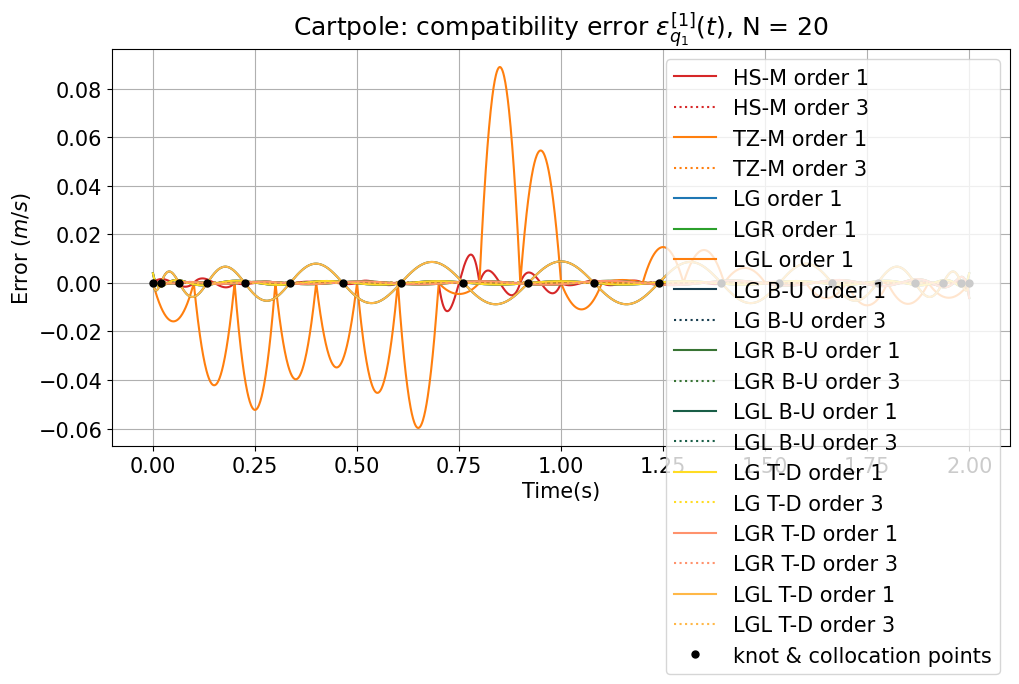

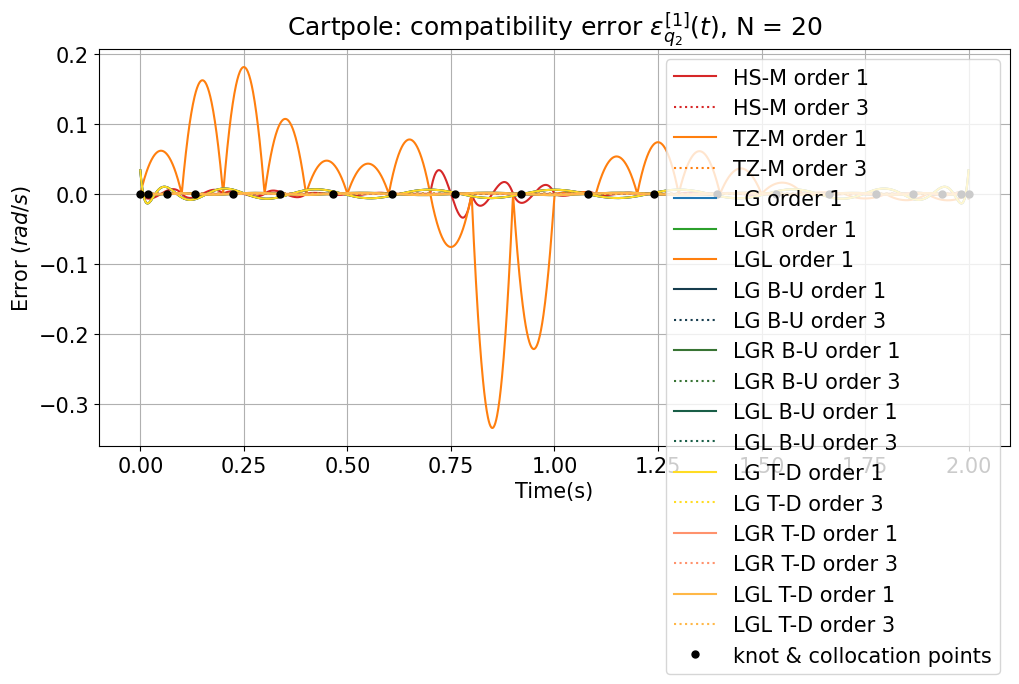

In [604]:
#schemes = ['trapz', 'trapz_mod']
ylabels = ['Error $(m/s)$','Error $(rad/s)$']
N = 20
save = False

for component in range(2):
    plt.figure(figsize=oct_fig_size)
    t_arr = np.linspace(
            0, results[key][N]["t"][-1], results[key][N]['error']['compat_err_1_interp'].shape[0]
        )
    for key in results.keys():
        scheme = results[key]['scheme']
        plot_kw = scheme_kwargs(scheme, longlabel=False)
        plot_kw['ls'] = '-' if results[key]['order'] == 1 else ':'
        plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
        plot_kw['marker'] = ''
        plt.plot(t_arr, results[key][N]['error']['compat_err_1_interp'][:,component], **plot_kw)
    plt.plot(
        results[key][N]["t"],
        np.zeros(len(results[key][N]["t"])),
        "ok",
        ms=5,
        label="knot & collocation points",
    )
    plt.legend()
    plt.grid()
    plt.title(r'Cartpole: compatibility error $\varepsilon^{[1]}_{q_'+f'{component+1}}}(t)$, N = {N}')
    plt.xlabel("Time(s)")
    plt.ylabel(ylabels[component])
    plt.tight_layout(pad=0.0)
                     
    if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'first_order_dyn_error',
            schemes_printed = schemes,
            save_format = 'pdf',
            N = N,
            q_counter = component,
        )

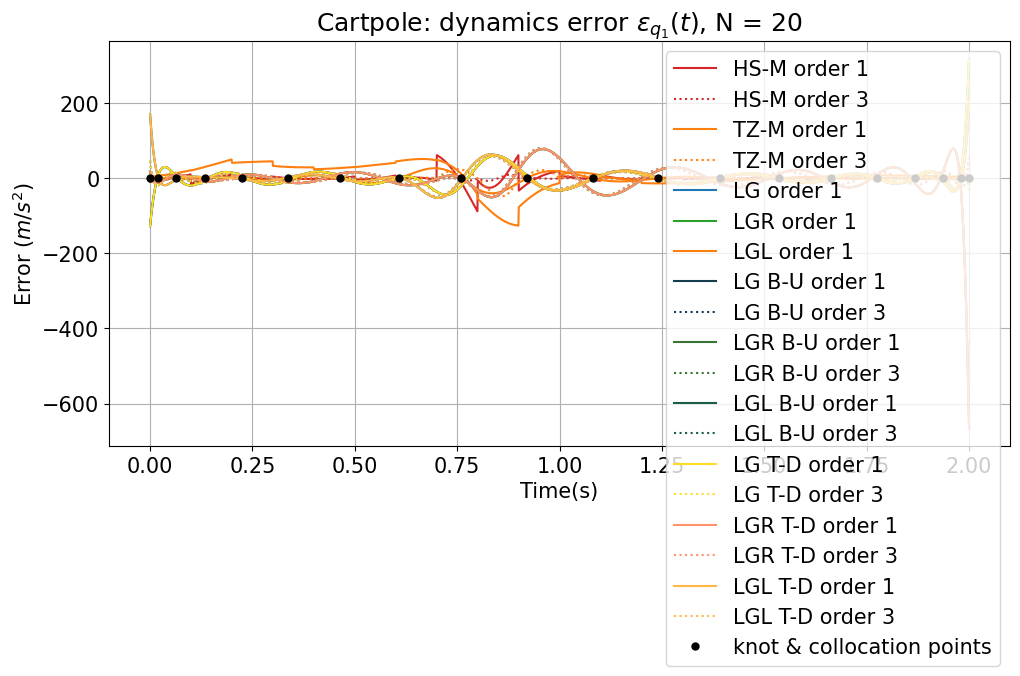

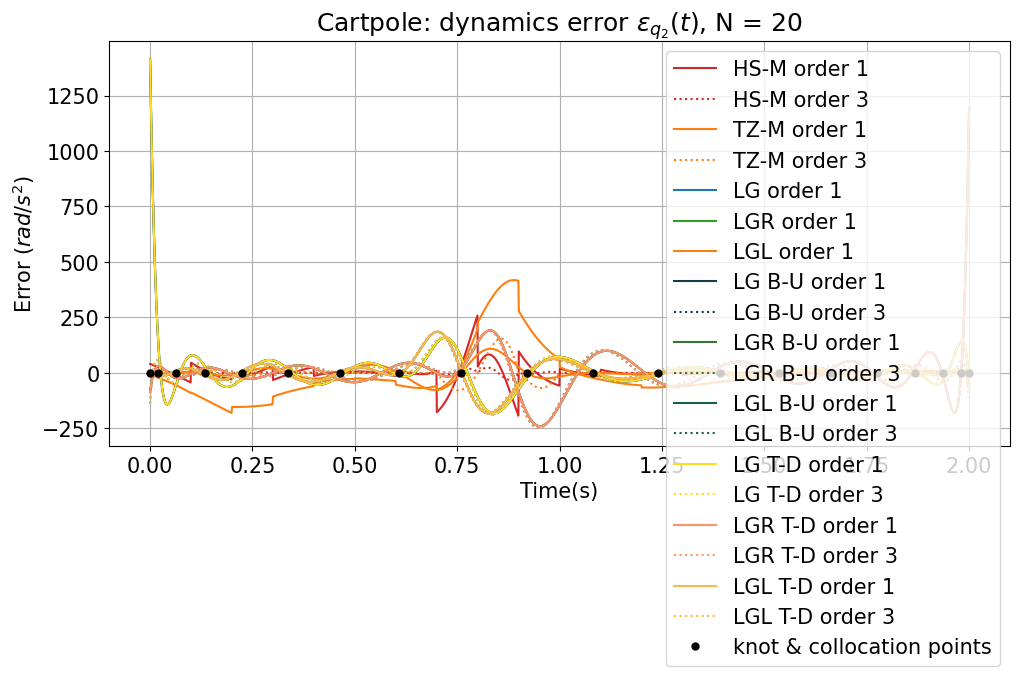

In [605]:
ylabels = ['Error $(m/s^2)$','Error $(rad/s^2)$']
N = 20
for component in range(2):
    plt.figure(figsize=oct_fig_size)
    t_arr = np.linspace(
            0, results[key][N]["t"][-1], results[key][N]['error']['dyn_err_interp'].shape[0]
        )
    for key in results.keys():
        scheme = results[key]['scheme']
        plot_kw = scheme_kwargs(scheme, longlabel=False)
        plot_kw['ls'] = '-' if results[key]['order'] == 1 else ':'
        plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
        plot_kw['marker'] = ''
        plt.plot(t_arr, results[key][N]['error']["dyn_err_interp"][:,component], **plot_kw)
    plt.plot(
        results[key][N]["t"],
        np.zeros(len(results[key][N]["t"])),
        "ok",
        ms=5,
        label="knot & collocation points",
    )
    plt.legend()
    plt.grid()
    plt.title(r'Cartpole: dynamics error $\varepsilon_{q_'+f'{component+1}}}(t)$, N = {N}')
    plt.xlabel("Time(s)")
    plt.ylabel(ylabels[component])
    plt.tight_layout(pad=0.0)
    if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'second_order_dyn_error',
            schemes_printed = schemes,
            save_format = 'pdf',
            N = N,
            q_counter = component,
        )

In [606]:
results.keys()

dict_keys(['hsn_parab_1', 'hsn_parab_3', 'trapz_n_1', 'trapz_n_3', 'LG_1', 'LGR_1', 'LGL_1', 'BU_LG_1', 'BU_LG_3', 'BU_LGR_1', 'BU_LGR_3', 'BU_LGL_1', 'BU_LGL_3', 'TD_LG_1', 'TD_LG_3', 'TD_LGR_1', 'TD_LGR_3', 'TD_LGL_1', 'TD_LGL_3'])

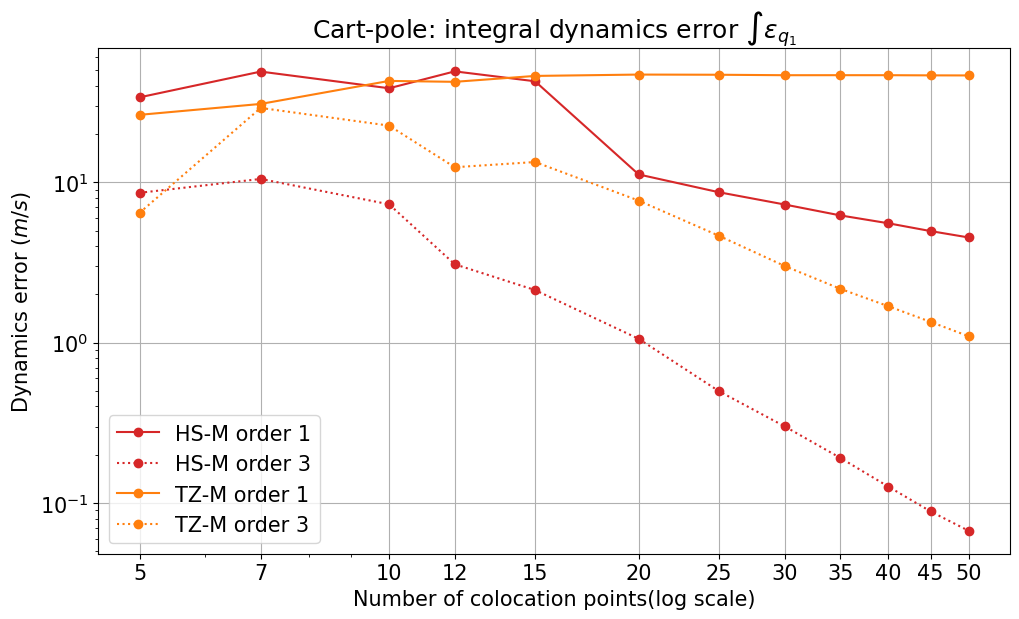

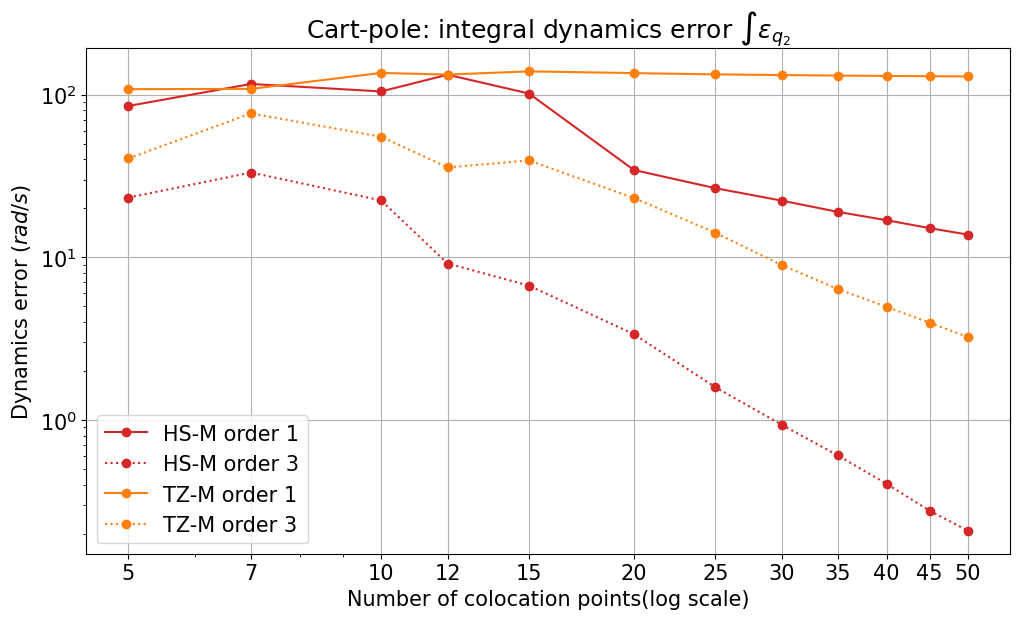

In [607]:
data_array = ['err_q_acum','err_v_acum','err_3_acum','cpudt']
schemes = [
    #'LG2_2',
    'hsn_parab_1',
    'hsn_parab_3',
    #'hs_parab_3',
    #'hs_parab_1',
    'trapz_n_1',
    'trapz_n_3',
    #'trapz_3',
    #'trapz_1',
    #'LG_1',
    #'LGR_1',
    #'LGL_1',
    #'CG_1',
    #'BU_LG_1',
    #'BU_LG_3',
    #'BU_LGR_1',
    #'BU_LGR_3',
    #'BU_LGL_1',
    #'BU_LGL_3'
    #'BU_CG_1',
    #'BU_CG_3',
    #'TD_LG_1',
    #'TD_LG_3',
    #'TD_CG_1',
    #'TD_CG_3',
]


save = True
#save = False

data_key = data_array[2]
for qq in range(2):
    plt.figure(figsize=oct_fig_size)
    plt.title(r'Cart-pole: integral dynamics error $\int\varepsilon_{q_'+f'{qq+1}}}$')
    for key in schemes: #results.keys():
        scheme = results[key]['scheme']
        #if "C" in scheme:
            #continue
            #pass
        plot_kw = scheme_kwargs(scheme, longlabel=False)
        plot_kw['ls'] = '-' if results[key]['order'] == 1 else ':'
        plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
        N_arr = results[key]['N_arr']
        if len(results[key][data_key].shape) == 1:
            plt.plot(N_arr,
             results[key][data_key],
             **plot_kw)
        else:
            plt.plot(N_arr,
             results[key][data_key][:,qq],
             **plot_kw)
    plt.yscale('log')
    plt.xscale('log')
    ticks = np.array(results[key]['N_arr'])
    #ticks = np.arange(0, results[key]['N_arr'][-1]+1, 25)
    plt.xticks(ticks, labels=ticks)
    plt.xlabel('Number of colocation points(log scale)')
    plt.grid()
    plt.legend()#loc = 'lower left'
    units = 'm/s' if qq == 0 else'rad/s'
    plt.ylabel(f'Dynamics error $({units})$')
    plt.tight_layout(pad = 0.0)
    # If you are running the notebook locally and want to save the plots,
    # uncomment the next line
    if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'integ_dyn_error',
            schemes_printed = schemes,
            save_format = 'png',
            N = None,
            q_counter = qq,
            add = f'model {model} ODE 3 HS{order} cost {cost_f}'
        )

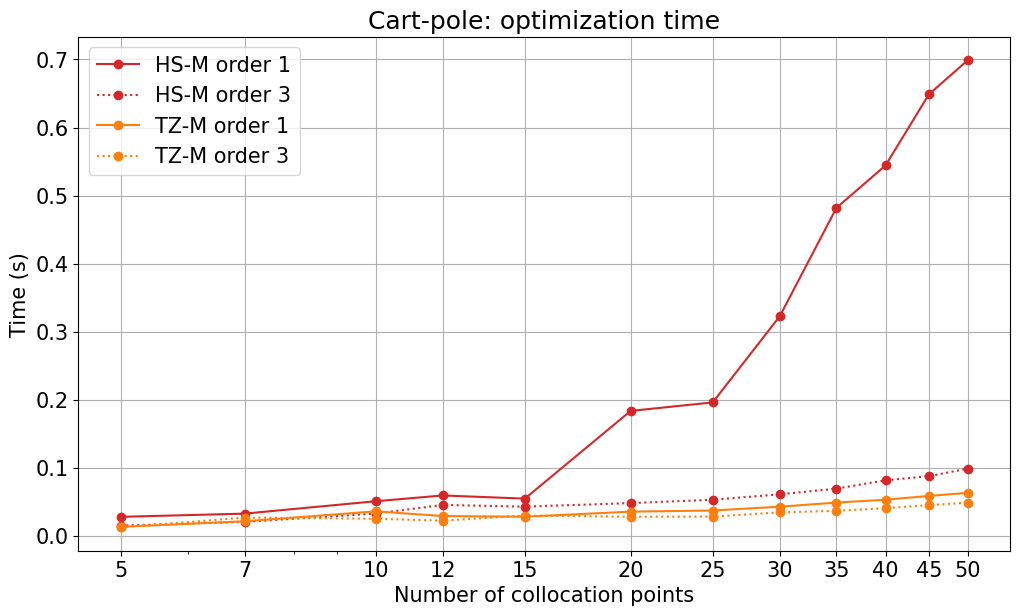

In [608]:

plt.figure(figsize=[10,6])
for key in schemes:
    scheme = results[key]['scheme']
    #if "C" not in scheme:
            #continue
            #pass
    plot_kw = scheme_kwargs(scheme, longlabel=False)
    plot_kw['ls'] = '-' if results[key]['order'] == 1 else ':'
    plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
    plt.plot(results[key]['N_arr'],
             results[key][f'cpudt'],
             **plot_kw)
plt.grid()
plt.legend()
plt.title('Cart-pole: optimization time')
plt.xlabel('Number of collocation points')
plt.ylabel('Time (s)')
#plt.yscale('log')
plt.xscale('log')
plt.tight_layout(pad = 0.0)
ticks = np.array(results[key]['N_arr'])
#ticks = np.array(results[key]['N_arr'][:6]+results[key]['N_arr'][6:20:2]+[150,200,300,400])
#ticks = np.arange(0, results[key]['N_arr'][-1]+1, 25)
plt.xticks(ticks, labels=ticks)
_ = []
# If you are running the notebook locally and want to save the plots,
# uncomment the next line
if save:
    save_fig(
        problem_name = problem_name,
        graph_name = 'opt_time',
        schemes_printed = schemes,
        save_format = 'png',
        N = None,
        q_counter = None,
        add = f'model {model} ODE 3 HS{order} cost {cost_f}'
    )

# Here we print the data shown in Table II of the paper
for scheme in ['trapz', 'trapz_mod', 'hs_parab', 'hs_mod_parab']:
    key = scheme 
    #for N in [25,50]:#results[key]['N_arr']:
    N = 25 if 'hs' in scheme else 50
    print('scheme:', scheme, 'N:', N,'\n\ttime:', results[key][N][f'cpudt'],
              '\n\tErr 1:', results[key][N]['err_q'], '\n\tErr 2:', results[key][N]['err_2'])

## Animation

from matplotlib import animation, rc
import matplotlib.patches as patches
from matplotlib.transforms import Affine2D
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 200

def create_anim(X, U, params):
    [g_n, l_n, m0_n, m1_n] = params
    
    N = X.shape[0]
    fig, ax = plt.subplots()
    y_scale = 1
    min_x_cart = np.min(X[:,0])
    max_x_cart = np.max(X[:,0])
    cart_displ = max_x_cart-min_x_cart
    size_x = 2*y_scale + cart_displ
    size_y = 2*y_scale
    draw_width = 14
    draw_height = draw_width / size_x * size_y
    
    x_0 = X[:,0]
    y_0 = np.zeros_like(x_0)
    x_1 = x_0 + l_n*np.sin(X[:,1])
    y_1 = y_0 - l_n*np.cos(X[:,1])
    
    x_cm = (m0_n * x_0 + m1_n * x_1)/(m0_n + m1_n)
    y_cm = (m0_n * y_0 + m1_n * y_1)/(m0_n + m1_n)

    fig.set_dpi(72)
    fig.set_size_inches([draw_width,draw_height])
    ax.set_xlim(( min_x_cart-y_scale, max_x_cart+y_scale))
    ax.set_ylim(( -y_scale, y_scale))

    #circle1 = plt.Circle((0, 0), l_n, color='b', ls = ":", fill=False)
    #ax.add_artist(circle1)
    ax.plot([min_x_cart - l_n, max_x_cart + l_n], [0,0], 'k', lw=1, ls = ':')

    line1, = ax.plot([], [], lw=2)
    line3, = ax.plot([], [], 'k', lw=1, ls = ':')
    #line_cm, = ax.plot([], [], 'g', lw=1, ls = ':')
    point0, = ax.plot([], [], marker='s', markersize=10, color="k")
    point1, = ax.plot([], [], marker='o', markersize=7, color="red")
    #point_cm, = ax.plot([], [], marker='o', markersize=10, color="green")
    u_max = max(np.max(np.abs(U[:])),1e-15)
    arrow_w = 0.1*l_n
    arrow_l = 0.7*l_n
    u_arrow = patches.Arrow(0, 0, 0, -arrow_l, color = 'gray',width = arrow_w)
    ax.add_patch(u_arrow)
    
    print_vars = [X[:,0], X[:,1], U[:], np.linspace(0, N-1, N, dtype=int)]
    print_var_names = ['q_0', 'q_1', 'u_0', 'step']
    texts = []
    ii = 0.8
    for arr in print_vars:
        texts.append(ax.text(-0.8, ii, "", fontsize = 12))
        ii -= 0.2*l_n
        
    xx_interpolated, uu_interpolated = interpolated_array(
        X,
        U,
        F = F_nump,
        h = 2/(N-1),
        t_array = np.linspace(0, 2, 5*(N-1)+1),
        params = params,
        scheme = 'hs_mod_parab',
        u_scheme = 'parab',
        scheme_params = {'u_c' : results['hs_mod_parab_lin'][N-1]['u_c']}
    )
    x_0_interp = xx_interpolated[:,0]
    y_0_interp = np.zeros_like(x_0_interp)
    x_1_interp = x_0_interp + l_n*np.sin(xx_interpolated[:,1])
    y_1_interp = y_0_interp - l_n*np.cos(xx_interpolated[:,1])
    
    def init():
        line1.set_data([], [])
        line3.set_data([], [])
        #line_cm.set_data([], [])
        point1.set_data([], [])
        #circle1.center = (0, 0)
        return (line1,)
    def animate(i):
        #circle1.center = (x_0[i], y_0[i])
        point0.set_data(x_0[i], y_0[i])
        line1.set_data([x_0[i], x_1[i]], [y_0[i], y_1[i]])    
        point1.set_data(x_1[i], y_1[i])
        #point_cm.set_data(x_cm[i], y_cm[i])
        line3.set_data(x_1_interp[:5*i+1], y_1_interp[:5*i+1])
        #line_cm.set_data(x_cm[:i], y_cm[:i])
        trans = Affine2D()
        u_arrow._patch_transform = trans.scale(U[i] * arrow_l / u_max, arrow_w).translate(x_0[i],0)
        for ii in range(len(texts)):
            text = texts[ii]
            name = print_var_names[ii]
            arr = print_vars[ii]
            if name == 'step':
                text.set_text("$step$ = " + str(arr[i]))
            else:
                text.set_text("$" + name + "$ = %.3f" % arr[i])
        return (line1,u_arrow)
    frame_indices = np.concatenate((np.zeros(10, dtype=int), np.arange(0, N, 1), np.ones(15, dtype=int)*(N-1)))
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frame_indices, interval=20, 
                               blit=True)
    return anim

anim = create_anim(results['hs_parab_lin'][25]['x'], results['hs_parab_lin'][25]['u'], params)

HTML(anim.to_jshtml())

f = r"cartpole_animation.mp4" 
writervideo = animation.FFMpegWriter(fps=12) 
# If you are running the notebook locally and want to save the animation,
# uncomment the next line
#anim.save(f, writer=writervideo)